The case study is from an open source dataset from Kaggle. 

Link to the Kaggle project site:

https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling (Links to an external site.)Links to an external site.

Given a Bank customer, can we build a classifier which can determine whether they will leave or not using Neural networks?

 bank.csvView in a new window

The points distribution for this case is as follows:

1. Read the dataset
2. Drop the columns which are unique for all users like IDs  ( 5 marks)
3. Distinguish the feature and target set (5 points)
4. Divide the data set into Train and test sets
5. Normalize the train and test data (5 points)
6. Initialize & build the model (20 points)
7. Optimize the model (10 points)
8. Predict the results using 0.5 as a threshold (10 points)
9. Print the Accuracy score and confusion matrix (5 points)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization
from keras import Sequential, regularizers
from sklearn.metrics import f1_score, accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE, ADASYN # SMOTE = synthetic minority oversampling technique, # ADASYN = adaptive synthetic
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
df=pd.read_csv('drive/My Drive/Colab Notebooks/Churn_Modelling.csv')
#df = pd.read_csv('Churn_Modelling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.shape

(10000, 14)

In [0]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

## Common functions

In [0]:
def get_callbacks(patience=10):
    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=1e-5, patience=patience, verbose=1)
    es = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto')
    return [es, lr_reduce]

In [0]:
def prep_x_train_y_train(df):
    x = df.drop('Exited', axis=1)
    y = df['Exited']
    x = pd.get_dummies(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=100)
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    return x_train, x_test, y_train, y_test

In [0]:
# Builds a neural network with
# 1. An Input Layer 
# 2. x no. of hidden layers (each of same size specified by provided list layer_sizes. If x = 2, layer_sizes = [32, 32])
# An output layer
def create_dense(layer_sizes, dropout=False, batchNorm=False, opt=Adam(), acti_fn_hidden_layr='relu', regularize=True):
    model = Sequential()
    if regularize:
        model.add(Dense(units = layer_sizes[0], \
                        kernel_initializer='glorot_normal', \
                        activation=acti_fn_hidden_layr, \
                        input_shape=(NUM_COLUMNS,), \
                        kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(Dense(units = layer_sizes[0], \
                kernel_initializer='glorot_normal', \
                activation=acti_fn_hidden_layr, \
                input_shape=(NUM_COLUMNS,)))


    for s in layer_sizes[1:]:
        if regularize:
            model.add(Dense(units = s, activation = acti_fn_hidden_layr, kernel_regularizer=regularizers.l2(0.01)))
        else:
            model.add(Dense(units = s, activation = acti_fn_hidden_layr))

        if batchNorm:
            model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(0.25))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [0]:
def evaluate(model, batch_size=128, epochs=30, earlyStop=True, desc='Model accuracy'):
    callbacks = get_callbacks(patience=6)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False, callbacks=callbacks)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    optimalF1 = 0
    optimalTh = 0
    for th in thresholds:
        preds = np.where(y_train_pred > th, 1, 0)
        f1Score = f1_score(y_train, preds)
        if(optimalF1 < f1Score):
            optimalF1 = f1Score
            optimalTh = th
    
    #optimalTh = 0.5
    print('optimalTh=', optimalTh)
    y_train_pred = np.where(y_train_pred > optimalTh, 1, 0)
    y_test_pred = np.where(y_test_pred > optimalTh, 1, 0)
    
    f1_train = f1_score(y_train, y_train_pred)
    f1_test  = f1_score(y_test,  y_test_pred)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    n_epochs = len(history.history['loss'])
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['loss'])
    plt.title(desc)
    plt.ylabel('accuracy/loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation', 'train_loss'], loc='best')
    plt.show()

    print(f'F1_Train = {f1_train}, F1_Test = {f1_test},\nAcc_Train = {acc_train}, Acc_Test = {acc_test}, Precision={precision}, Recall ={recall}')
    print(confusion_matrix(y_test, y_test_pred))
    print('\n\n')
    #print(f'Test loss: {loss:.3}')
    #print('Test score:', score)
    #print(f'Test accuracy: {accuracy:.3}')
    return [f1_train, f1_test, acc_train, acc_test, n_epochs, precision, recall, optimalTh]

In [0]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: skyblue' if v else '' for v in is_max]

In [0]:
def get_IQR(dataset, field):
    """
    Calculates and returns IQR, Lower Whisker and Upper Whisker
    """
    Q1 = np.quantile(dataset[field], 0.25)
    Q3 = np.quantile(dataset[field], 0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return IQR, lower, upper

In [0]:
def grab_outliers_IQR(dataset, field):
    _, lower, upper = get_IQR(dataset, field)
    return dataset[(dataset[field] < lower) | (dataset[field] > upper)]

In [0]:
def grab_outliers_ZScore(dataset, field):
    z = stats.zscore(dataset[field])
    return dataset[z > 3] 

In [0]:
def drawDistplot(df, name, color,  fig_size=(10,8), legend_loc='upper right', background_style='darkgrid', kde=True, hist=False, bins=None):
 
    skewness_kurtosis = ''
    
    sns.set(style=background_style)
    plt.figure(figsize=(15,8))
    
    s_k = name + ' --> skewness = ' + str(df.skew()) + ', kurtosis = ' + str(df.kurtosis()) + '\n'
    skewness_kurtosis = skewness_kurtosis + s_k
    ax=sns.distplot(df, hist=hist, kde=kde, label=name , color=color, bins=bins)
    ax.axvline(df.mean(),   color=color, linestyle='--', label='%s, Mean = %0.2f' %(name, df.mean()))
    ax.axvline(df.median(), color=color, linestyle='-',  label='%s, Median = %0.2f' %(name, df.median()))

    plt.legend(loc="upper right")
    plt.show()
    plt.close()
    print(skewness_kurtosis)

## Common functions END

In [17]:
x_train, x_test, y_train, y_test = prep_x_train_y_train(df)
x_train.shape

(8000, 13)

## EDA

### Credit Score

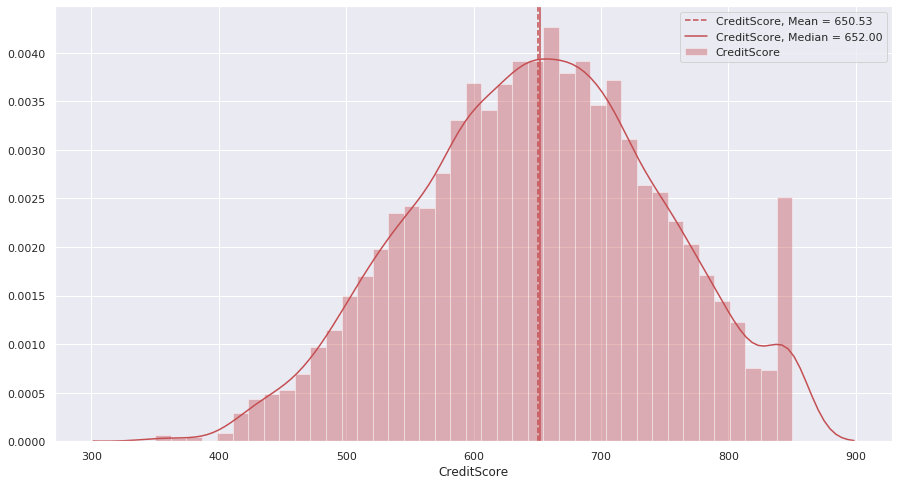

CreditScore --> skewness = -0.07160660820092675, kurtosis = -0.42572568480291295



In [18]:
drawDistplot(df['CreditScore'], 'CreditScore', 'r', hist=True)

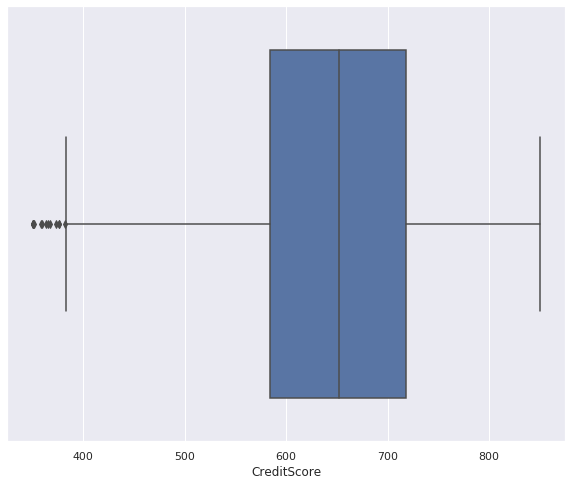

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(df['CreditScore'])
plt.show()
plt.close()

In [20]:
outliers = grab_outliers_ZScore(df, 'CreditScore')
outliers

Empty DataFrame
Columns: [CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []

### Geography          

In [21]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

### Gender

In [22]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

### Age

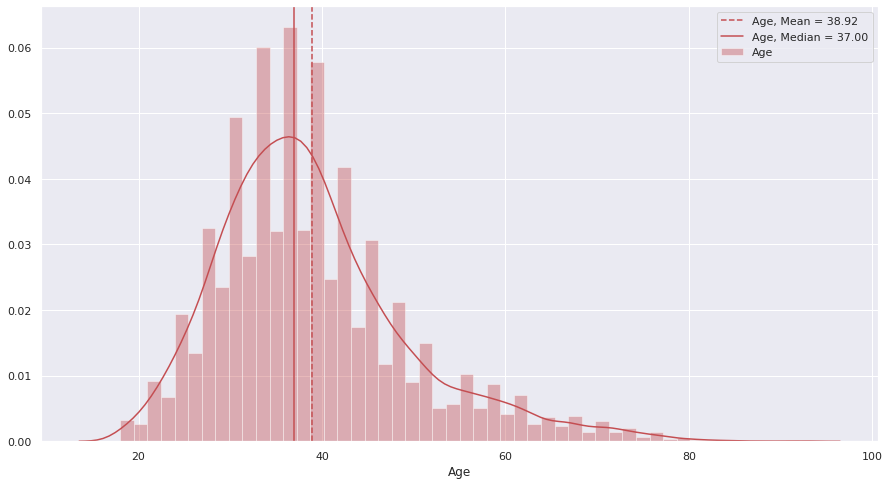

Age --> skewness = 1.0113202630234552, kurtosis = 1.3953470615086956



In [23]:
drawDistplot(df['Age'], 'Age', 'r', hist=True)

In [24]:
outliers = grab_outliers_IQR(df, 'Age')
len(outliers)

359

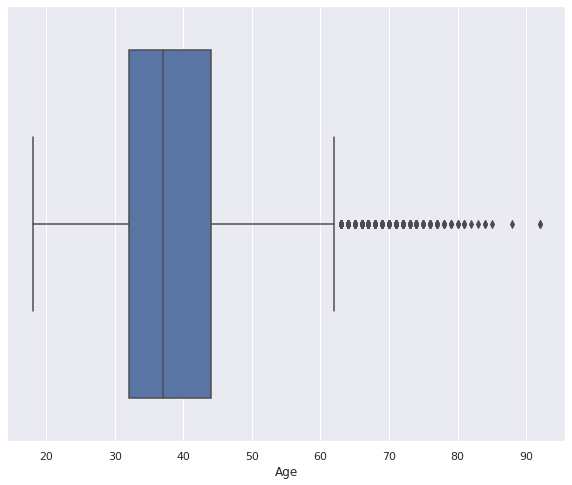

In [25]:
plt.figure(figsize=(10,8))
sns.boxplot(df['Age'])
plt.show()
plt.close()

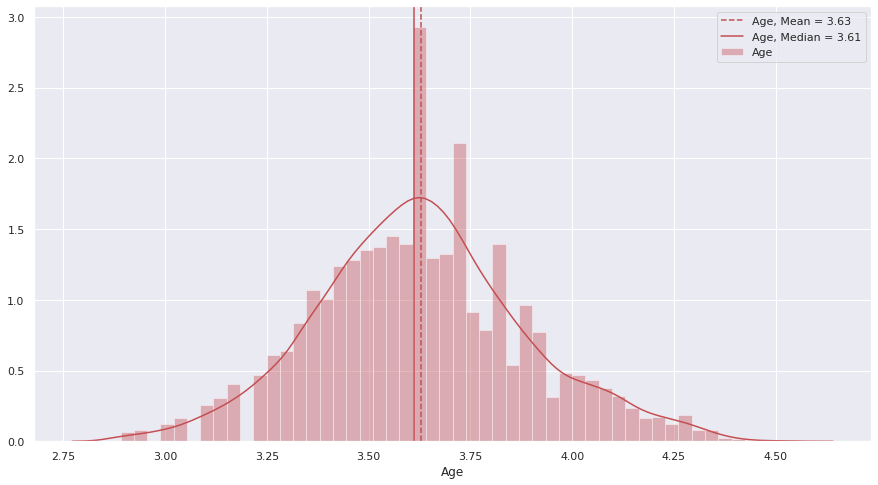

Age --> skewness = 0.182020112559587, kurtosis = 0.15279353072401447



In [26]:
drawDistplot(np.log(df['Age']), 'Age', 'r', hist=True)

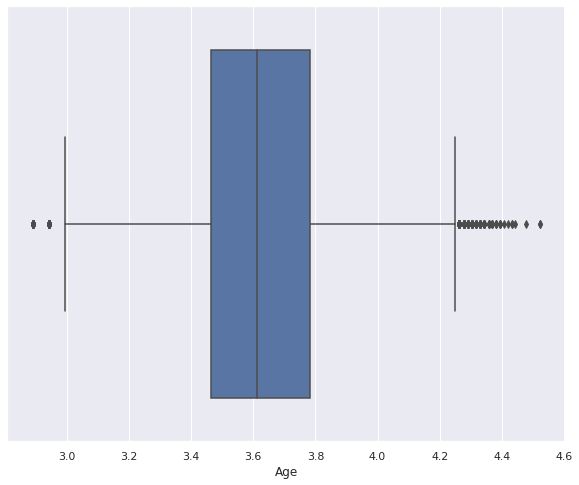

In [27]:
plt.figure(figsize=(10,8))
sns.boxplot(np.log(df['Age']))
plt.show()
plt.close()

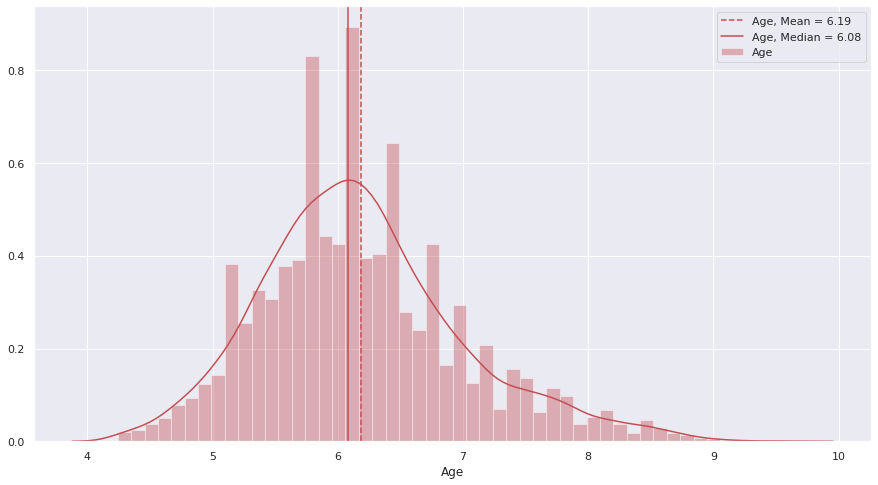

Age --> skewness = 0.5934049767753374, kurtosis = 0.530063322936897



In [28]:
drawDistplot(np.sqrt(df['Age']), 'Age', 'r', hist=True)

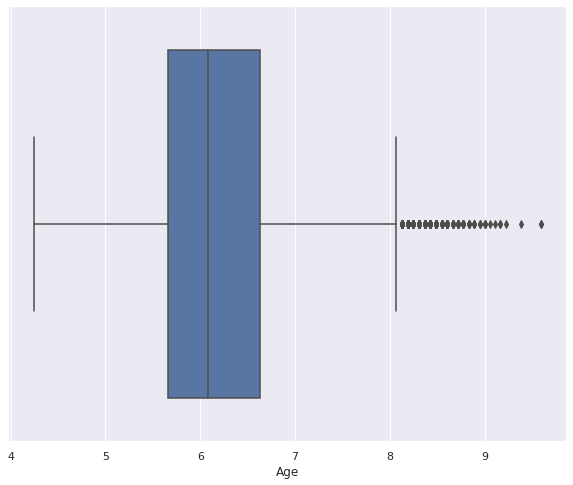

In [29]:
plt.figure(figsize=(10,8))
sns.boxplot(np.sqrt(df['Age']))
plt.show()
plt.close()

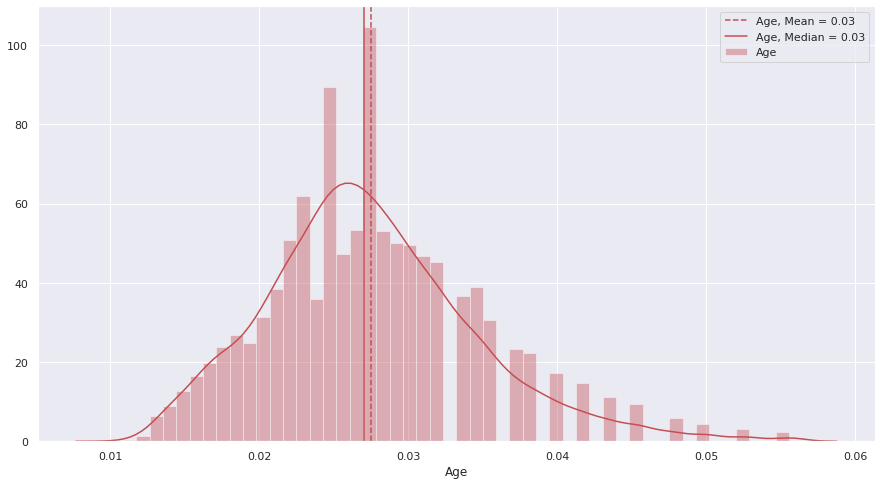

Age --> skewness = 0.653380397448114, kurtosis = 0.8465517606663626



In [30]:
drawDistplot(1/(df['Age']), 'Age', 'r', hist=True)

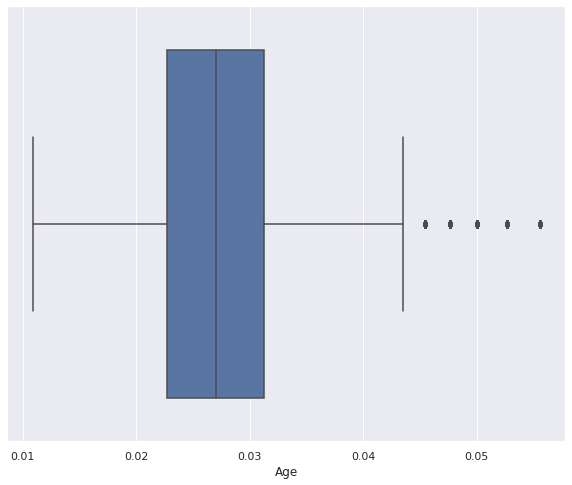

In [31]:
plt.figure(figsize=(10,8))
sns.boxplot(1/(df['Age']))
plt.show()
plt.close()

In [0]:
# Let's check if there are any outliers
OUTLIER_TREATMENT_STRATEGY = 'Log'
field = 'Age'
if OUTLIER_TREATMENT_STRATEGY == 'Whiskers':
    df.loc[outliers.index.tolist(), field] = lower
elif OUTLIER_TREATMENT_STRATEGY == 'Log':
    df[field] = np.log(df[field])
elif OUTLIER_TREATMENT_STRATEGY == 'Sqrt':
    df[field] = np.sqrt(df[field])
elif OUTLIER_TREATMENT_STRATEGY == 'Division':
    df[field] = 1/(df[field])

In [33]:
outliers =  grab_outliers_IQR(df, 'Age')
len(outliers)

182

In [0]:
### Tenure

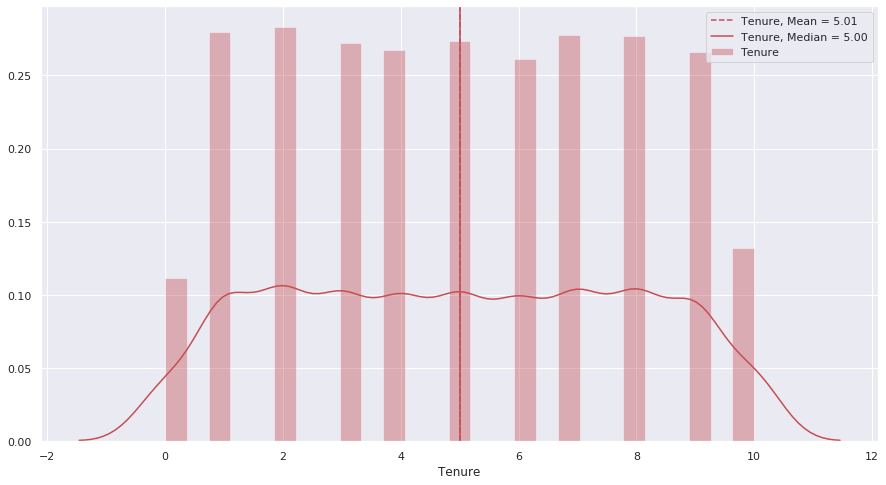

Tenure --> skewness = 0.01099145797717904, kurtosis = -1.1652252274891766



In [35]:
field = 'Tenure'
drawDistplot(df[field], field, 'r', hist=True)

In [36]:
outliers = grab_outliers_IQR(df, field)
field, len(outliers)

('Tenure', 0)

In [0]:
### Balance

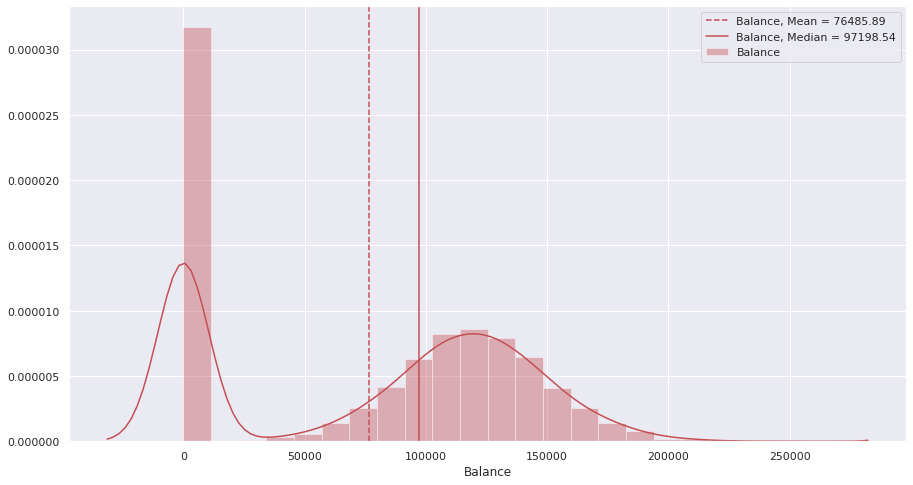

Balance --> skewness = -0.14110871094154384, kurtosis = -1.489411767941925



In [38]:
field = 'Balance'
drawDistplot(df[field], field, 'r', hist=True)

In [39]:
outliers = grab_outliers_IQR(df, field)
field, len(outliers)

('Balance', 0)

In [0]:
### NumOfProducts

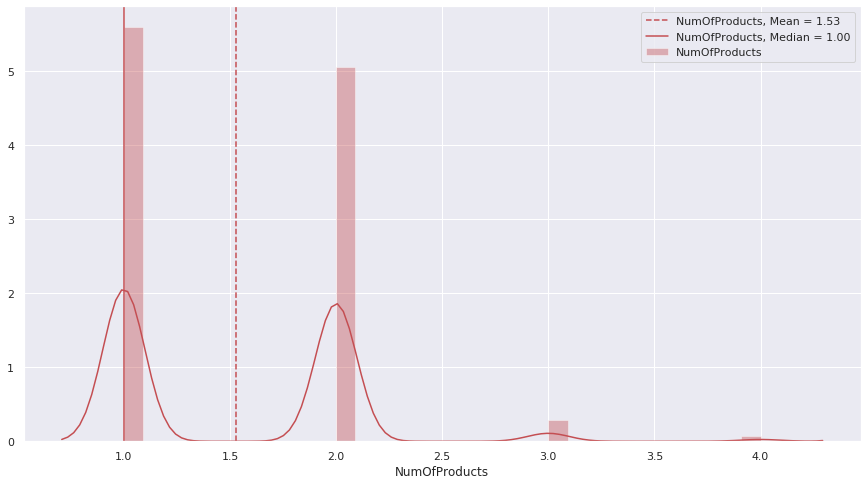

NumOfProducts --> skewness = 0.7455678882823168, kurtosis = 0.5829807629457178



In [41]:
field = 'NumOfProducts'
drawDistplot(df[field], field, 'r', hist=True)

In [42]:
df[field].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [0]:
### HasCrCard

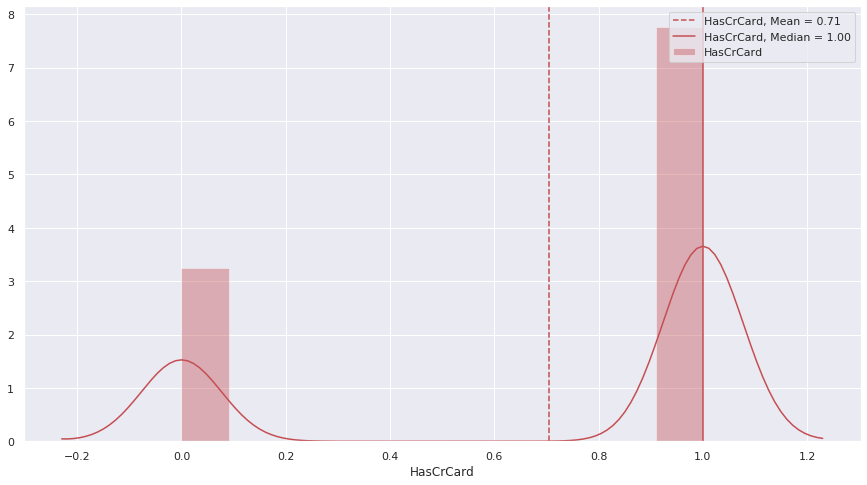

HasCrCard --> skewness = -0.9018115952400578, kurtosis = -1.1869732813556029



In [44]:
field = 'HasCrCard'
drawDistplot(df[field], field, 'r', hist=True)

In [45]:
df[field].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

### IsActiveMember

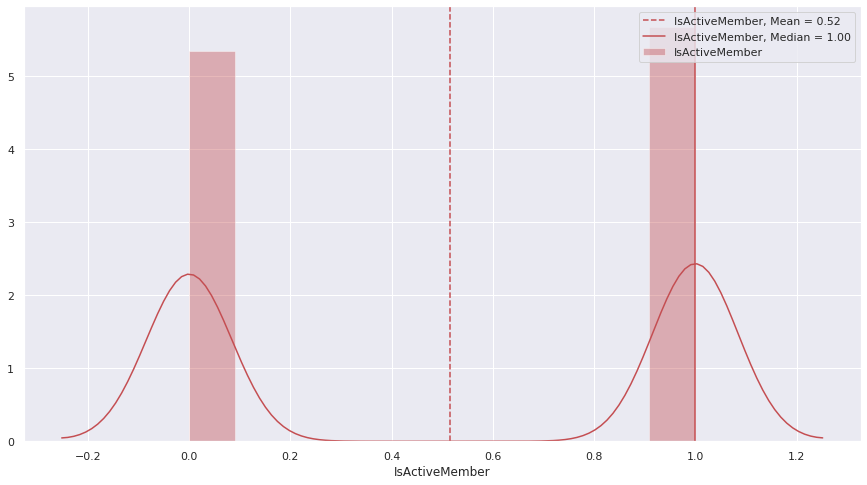

IsActiveMember --> skewness = -0.06043662833499078, kurtosis = -1.9967468033281526



In [46]:
field = 'IsActiveMember'
drawDistplot(df[field], field, 'r', hist=True)

In [47]:
df[field].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

### EstimatedSalary

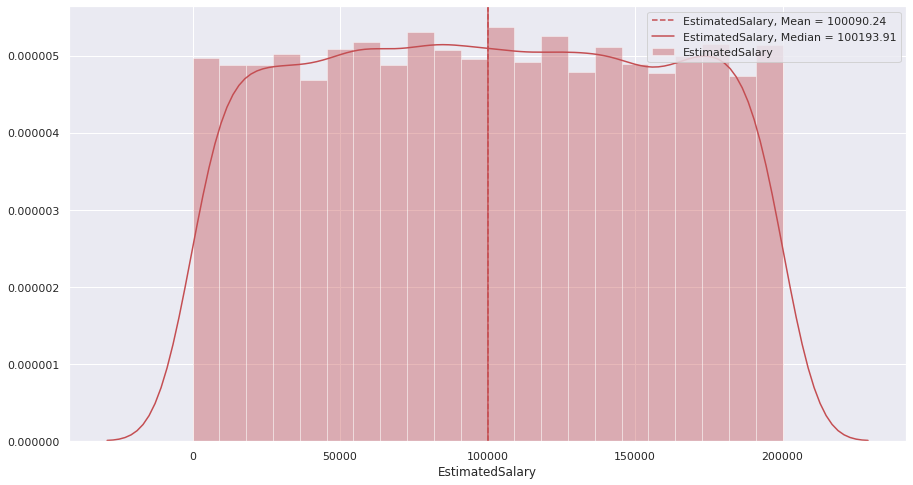

EstimatedSalary --> skewness = 0.0020853576615585162, kurtosis = -1.1815184473915485



In [48]:
field = 'EstimatedSalary'
drawDistplot(df[field], field, 'r', hist=True)

In [49]:
outliers = grab_outliers_IQR(df, field)
len(outliers)

0

## Just trying to understand the scores for some basic algorithms


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [51]:
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_nb = GaussianNB()
models = [model_lr, model_dt, model_rf, model_nb]
for model in models:
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    print("Model :: ", type(model))
    print("TRAIN REPORT")
    print(classification_report(y_train, y_train_pred))
    print("TEST REPORT")
    print(classification_report(y_test, y_test_pred))

Model ::  <class 'sklearn.linear_model.logistic.LogisticRegression'>
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      6375
           1       0.60      0.22      0.33      1625

    accuracy                           0.81      8000
   macro avg       0.72      0.59      0.61      8000
weighted avg       0.78      0.81      0.78      8000

TEST REPORT
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1588
           1       0.57      0.19      0.29       412

    accuracy                           0.80      2000
   macro avg       0.70      0.58      0.59      2000
weighted avg       0.77      0.80      0.76      2000



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model ::  <class 'sklearn.tree.tree.DecisionTreeClassifier'>
TRAIN REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6375
           1       1.00      1.00      1.00      1625

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

TEST REPORT
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1588
           1       0.52      0.50      0.51       412

    accuracy                           0.80      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.80      0.80      0.80      2000

Model ::  <class 'sklearn.ensemble.forest.RandomForestClassifier'>
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6375
           1       1.00      0.93      0.96      1625

    accuracy    

## Create Models






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '











Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00033: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


optimalTh= 0.35156643


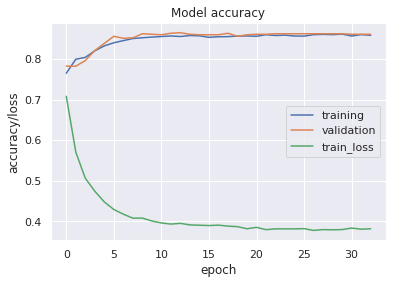

F1_Train = 0.6226964112512124, F1_Test = 0.5854304635761588,
Acc_Train = 0.854125, Acc_Test = 0.8435, Precision=0.6443148688046647, Recall =0.5364077669902912
[[1466  122]
 [ 191  221]]





[0.6226964112512124,
 0.5854304635761588,
 0.854125,
 0.8435,
 33,
 0.6443148688046647,
 0.5364077669902912,
 0.35156643]

In [52]:
NUM_COLUMNS = x_train.shape[1]
EPOCHS = 200
b_size = 32
reg = True
drop =True
nodes = 10
layers = 2
model = create_dense([nodes] * layers, regularize=reg,  dropout=drop)
optimizer = Adam()
res = evaluate(model, batch_size=b_size, epochs=EPOCHS)
res

In [53]:
res[7]

0.35156643

In [54]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [55]:
from sklearn.metrics import classification_report
optimalTh = res[7]
y_pred = model.predict(x_train, batch_size=b_size)
y_pred = np.where(y_pred > optimalTh, 1, 0)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6375
           1       0.66      0.59      0.62      1625

    accuracy                           0.85      8000
   macro avg       0.78      0.76      0.77      8000
weighted avg       0.85      0.85      0.85      8000



In [0]:
results = pd.DataFrame(columns=['MODEL', 'F1_TRAIN', 'F1_TEST', 'ACC_TRAIN', '  ACC_TEST  ', 'EPOCHS', 'Precision', 'Recall', 'Optimal_Threshold'])

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00023: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


optimalTh= 0.2586808


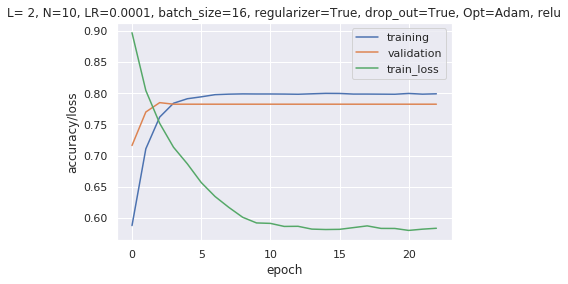

F1_Train = 0.4267231239708304, F1_Test = 0.4180790960451977,
Acc_Train = 0.695375, Acc_Test = 0.691, Precision=0.3415384615384615, Recall =0.5388349514563107
[[1160  428]
 [ 190  222]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.24937531


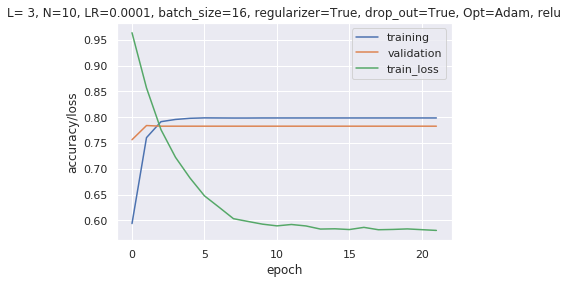

F1_Train = 0.4457720588235294, F1_Test = 0.4412032816773017,
Acc_Train = 0.6985, Acc_Test = 0.6935, Precision=0.3532846715328467, Recall =0.587378640776699
[[1145  443]
 [ 170  242]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.24407822


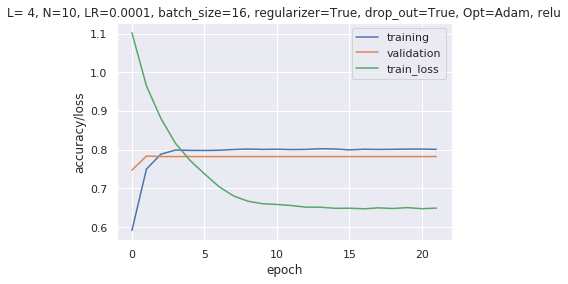

F1_Train = 0.4591381872213967, F1_Test = 0.456,
Acc_Train = 0.727, Acc_Test = 0.728, Precision=0.3877551020408163, Recall =0.5533980582524272
[[1228  360]
 [ 184  228]]




Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00070: early stopping
optimalTh= 0.2748356


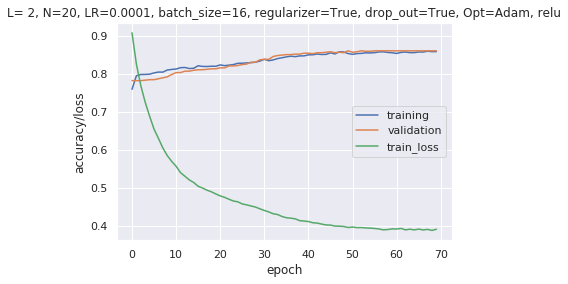

F1_Train = 0.6169912503528084, F1_Test = 0.6144994246260069,
Acc_Train = 0.830375, Acc_Test = 0.8325, Precision=0.5842450765864332, Recall =0.6480582524271845
[[1398  190]
 [ 145  267]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.23427987


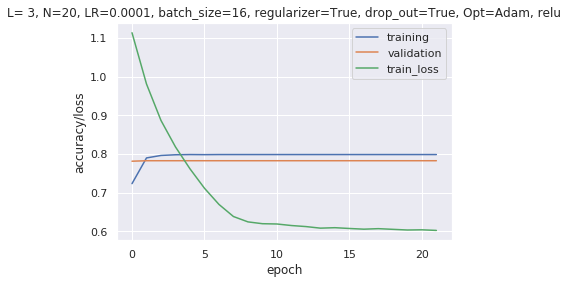

F1_Train = 0.48890921564143597, F1_Test = 0.4676056338028169,
Acc_Train = 0.720625, Acc_Test = 0.7165, Precision=0.38131699846860645, Recall =0.6043689320388349
[[1184  404]
 [ 163  249]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.2343986


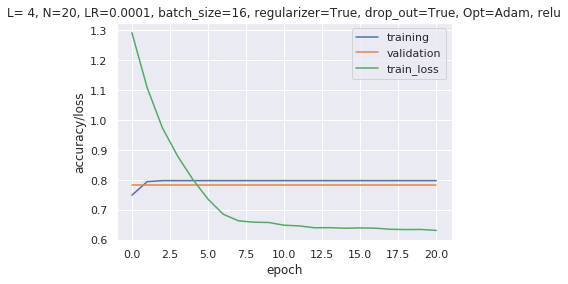

F1_Train = 0.4513715710723192, F1_Test = 0.4341880341880342,
Acc_Train = 0.67, Acc_Test = 0.669, Precision=0.33509234828496043, Recall =0.616504854368932
[[1084  504]
 [ 158  254]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00026: early stopping
optimalTh= 0.21542281


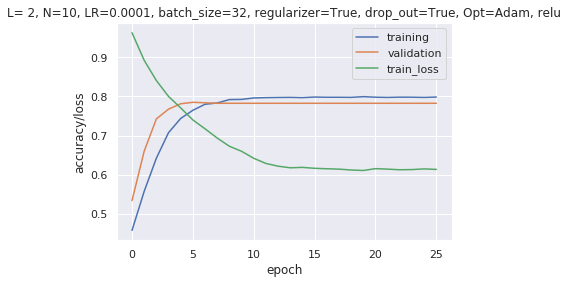

F1_Train = 0.3878066914498141, F1_Test = 0.38852361028093246,
Acc_Train = 0.485375, Acc_Test = 0.4885, Precision=0.25773195876288657, Recall =0.7888349514563107
[[652 936]
 [ 87 325]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.2382032


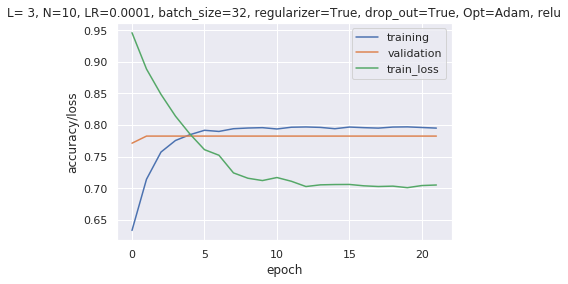

F1_Train = 0.39143526262964196, F1_Test = 0.37966101694915255,
Acc_Train = 0.54525, Acc_Test = 0.5425, Precision=0.2634054562558796, Recall =0.6796116504854369
[[805 783]
 [132 280]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.25625858


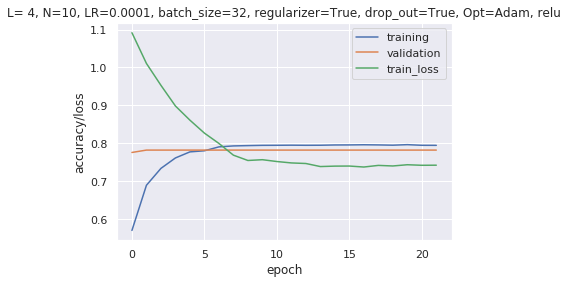

F1_Train = 0.42756622516556286, F1_Test = 0.41916167664670656,
Acc_Train = 0.65425, Acc_Test = 0.6605, Precision=0.3236459709379128, Recall =0.5946601941747572
[[1076  512]
 [ 167  245]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.24390197


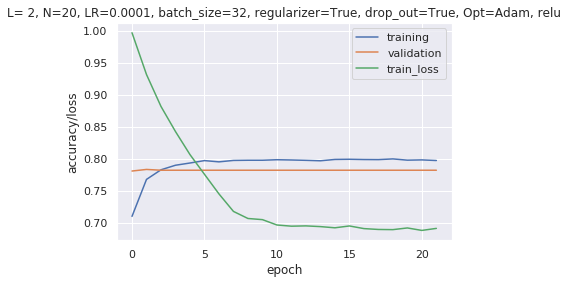

F1_Train = 0.4379694969269292, F1_Test = 0.4375,
Acc_Train = 0.691375, Acc_Test = 0.694, Precision=0.3520710059171598, Recall =0.5776699029126213
[[1150  438]
 [ 174  238]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00024: early stopping
optimalTh= 0.2452085


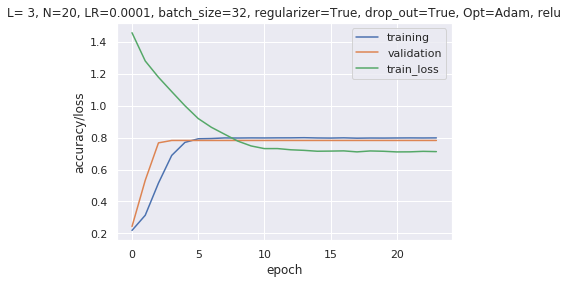

F1_Train = 0.4768423454255076, F1_Test = 0.4611111111111111,
Acc_Train = 0.713375, Acc_Test = 0.709, Precision=0.3727544910179641, Recall =0.6043689320388349
[[1169  419]
 [ 163  249]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.25727284


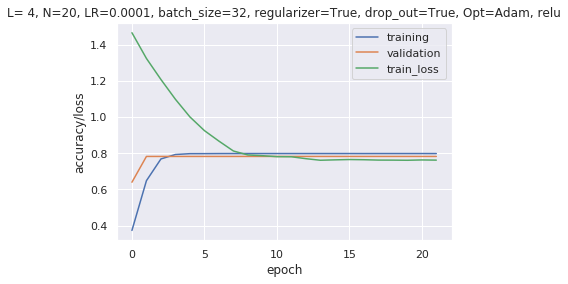

F1_Train = 0.4505850136918098, F1_Test = 0.4311377245508982,
Acc_Train = 0.724125, Acc_Test = 0.715, Precision=0.36610169491525424, Recall =0.5242718446601942
[[1214  374]
 [ 196  216]]




Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 00061: early stopping
optimalTh= 0.25588995


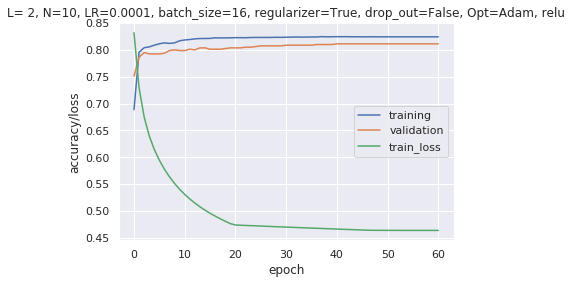

F1_Train = 0.5335071707953063, F1_Test = 0.5341880341880342,
Acc_Train = 0.776375, Acc_Test = 0.782, Precision=0.4770992366412214, Recall =0.6067961165048543
[[1314  274]
 [ 162  250]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.22895113


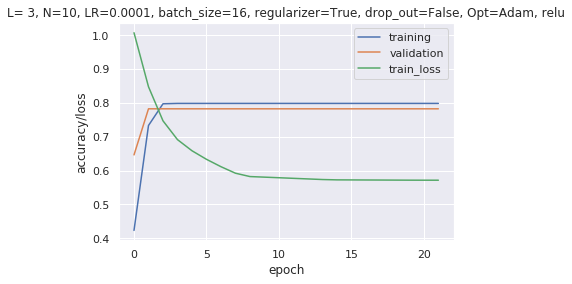

F1_Train = 0.4312080536912752, F1_Test = 0.42775510204081635,
Acc_Train = 0.661, Acc_Test = 0.6495, Precision=0.32226322263222634, Recall =0.6359223300970874
[[1037  551]
 [ 150  262]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.23334846


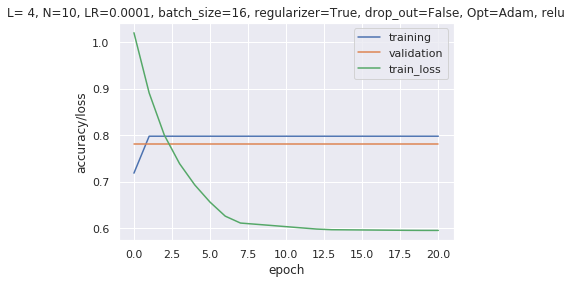

F1_Train = 0.47623485554520034, F1_Test = 0.46816479400749067,
Acc_Train = 0.719, Acc_Test = 0.716, Precision=0.38109756097560976, Recall =0.6067961165048543
[[1182  406]
 [ 162  250]]




Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00055: early stopping
optimalTh= 0.32692385


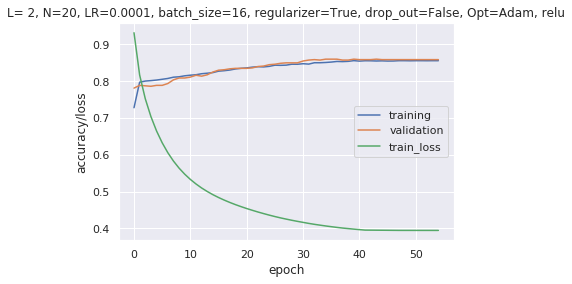

F1_Train = 0.6080832823025107, F1_Test = 0.5874999999999999,
Acc_Train = 0.84, Acc_Test = 0.835, Precision=0.6056701030927835, Recall =0.5703883495145631
[[1435  153]
 [ 177  235]]




Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00062: early stopping
optimalTh= 0.35879707


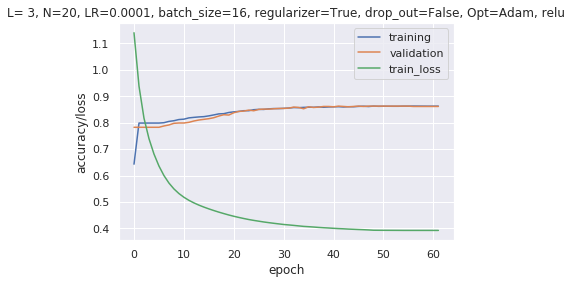

F1_Train = 0.6164339071126989, F1_Test = 0.5944517833553501,
Acc_Train = 0.852375, Acc_Test = 0.8465, Precision=0.6521739130434783, Recall =0.5461165048543689
[[1468  120]
 [ 187  225]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.25088403


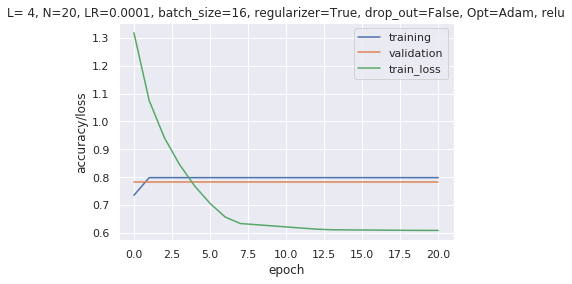

F1_Train = 0.49565433325055874, F1_Test = 0.48834853090172237,
Acc_Train = 0.746125, Acc_Test = 0.7475, Precision=0.4191304347826087, Recall =0.5849514563106796
[[1254  334]
 [ 171  241]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00026: early stopping
optimalTh= 0.2548156


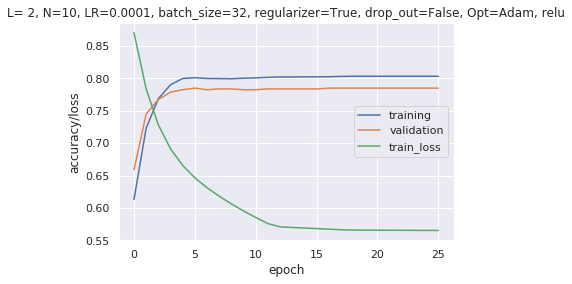

F1_Train = 0.4752917804817482, F1_Test = 0.49255213505461765,
Acc_Train = 0.735875, Acc_Test = 0.7445, Precision=0.41680672268907565, Recall =0.6019417475728155
[[1241  347]
 [ 164  248]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00024: early stopping
optimalTh= 0.23943779


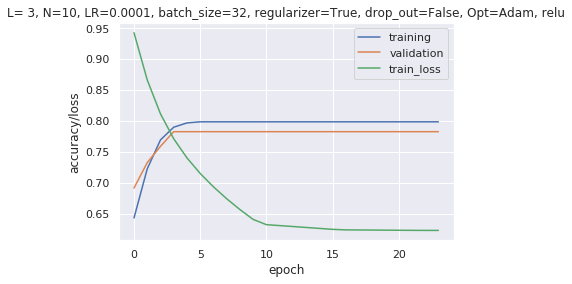

F1_Train = 0.4386649328131773, F1_Test = 0.4186882300089847,
Acc_Train = 0.67625, Acc_Test = 0.6765, Precision=0.33238231098430815, Recall =0.5655339805825242
[[1120  468]
 [ 179  233]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.21065095


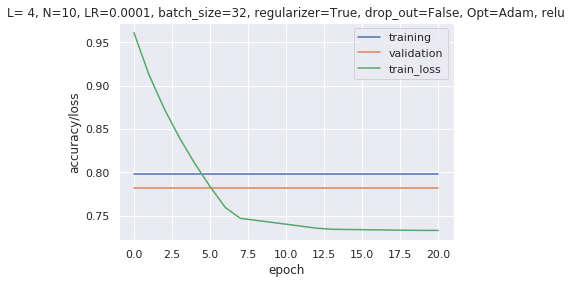

F1_Train = 0.42758620689655175, F1_Test = 0.42168674698795183,
Acc_Train = 0.6265, Acc_Test = 0.616, Precision=0.3056768558951965, Recall =0.6796116504854369
[[952 636]
 [132 280]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 00033: early stopping
optimalTh= 0.23975858


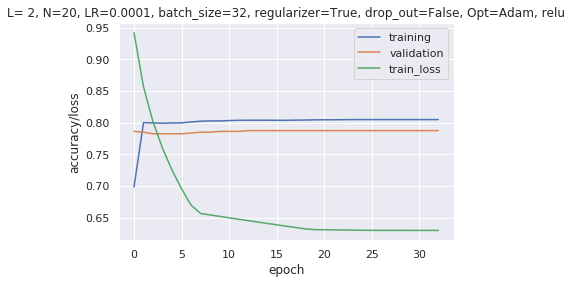

F1_Train = 0.4634510193933367, F1_Test = 0.4530612244897959,
Acc_Train = 0.73025, Acc_Test = 0.732, Precision=0.3908450704225352, Recall =0.5388349514563107
[[1242  346]
 [ 190  222]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 00043: early stopping
optimalTh= 0.24426368


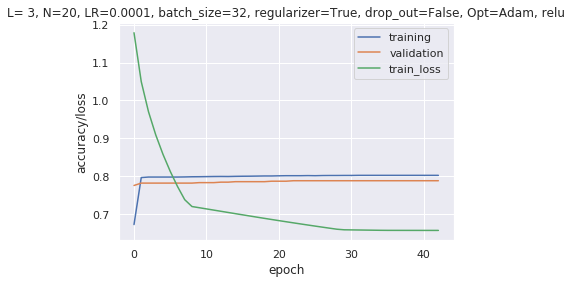

F1_Train = 0.47873074269947113, F1_Test = 0.4727272727272728,
Acc_Train = 0.716625, Acc_Test = 0.71, Precision=0.37790697674418605, Recall =0.6310679611650486
[[1160  428]
 [ 152  260]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.24311444


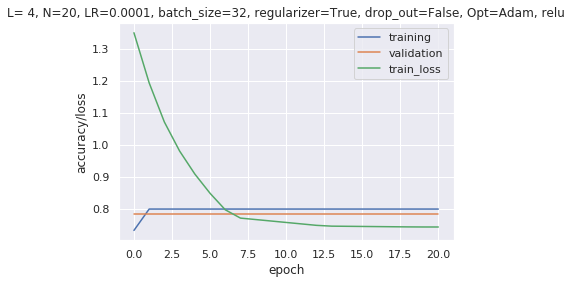

F1_Train = 0.49386352479135986, F1_Test = 0.48086359175662413,
Acc_Train = 0.74225, Acc_Test = 0.7355, Precision=0.40362438220757824, Recall =0.5946601941747572
[[1226  362]
 [ 167  245]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00026: early stopping
optimalTh= 0.2518026


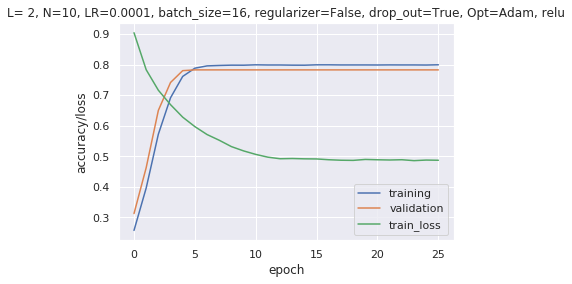

F1_Train = 0.4286031534532534, F1_Test = 0.4190647482014388,
Acc_Train = 0.678375, Acc_Test = 0.677, Precision=0.33285714285714285, Recall =0.5655339805825242
[[1121  467]
 [ 179  233]]




Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00023: early stopping
optimalTh= 0.23552793


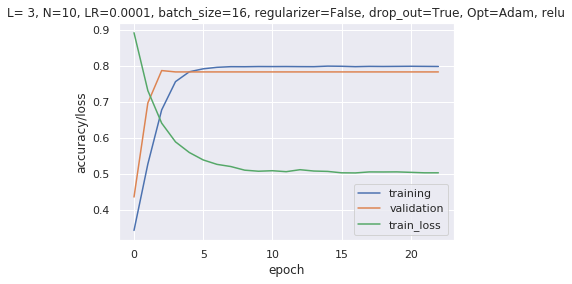

F1_Train = 0.40427719514702865, F1_Test = 0.36807817589576547,
Acc_Train = 0.637875, Acc_Test = 0.612, Precision=0.2769607843137255, Recall =0.5485436893203883
[[998 590]
 [186 226]]




Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00023: early stopping
optimalTh= 0.24565381


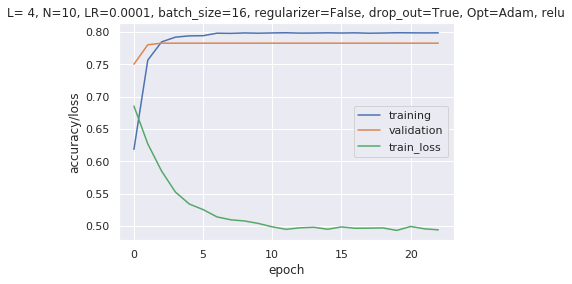

F1_Train = 0.44658971668415526, F1_Test = 0.4549214226633582,
Acc_Train = 0.670375, Acc_Test = 0.6705, Precision=0.3450439146800502, Recall =0.6674757281553398
[[1066  522]
 [ 137  275]]




Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00031: early stopping
optimalTh= 0.25354624


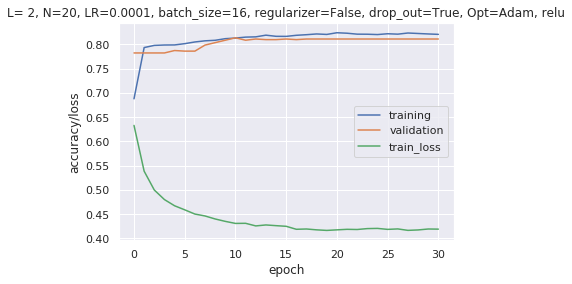

F1_Train = 0.5193532582067614, F1_Test = 0.4965786901270772,
Acc_Train = 0.75475, Acc_Test = 0.7425, Precision=0.4157119476268412, Recall =0.616504854368932
[[1231  357]
 [ 158  254]]




Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 00061: early stopping
optimalTh= 0.2628825


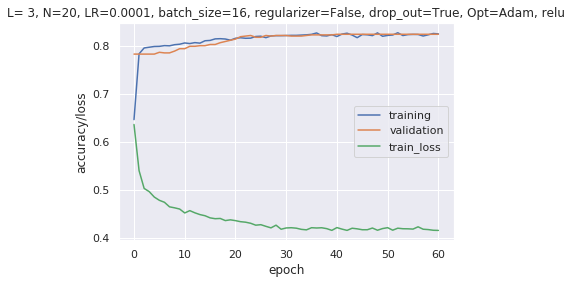

F1_Train = 0.539610225259428, F1_Test = 0.530901722391084,
Acc_Train = 0.772625, Acc_Test = 0.7685, Precision=0.45565217391304347, Recall =0.6359223300970874
[[1275  313]
 [ 150  262]]




Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00062: early stopping
optimalTh= 0.26150218


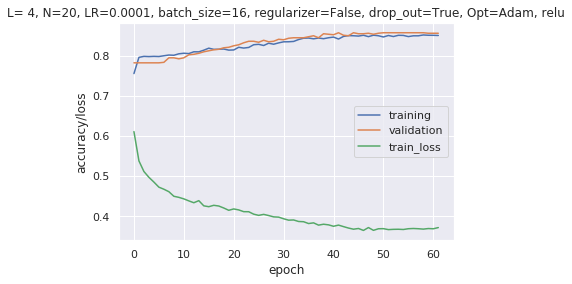

F1_Train = 0.6170895304753572, F1_Test = 0.5971563981042655,
Acc_Train = 0.835875, Acc_Test = 0.83, Precision=0.5833333333333334, Recall =0.6116504854368932
[[1408  180]
 [ 160  252]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00027: early stopping
optimalTh= 0.26698357


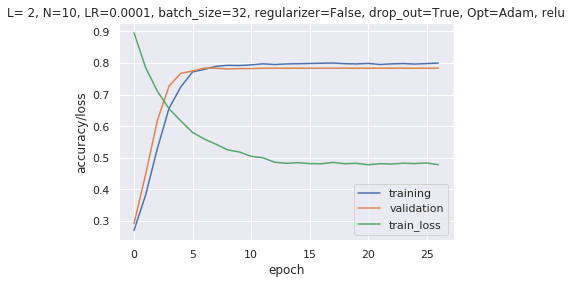

F1_Train = 0.4312408146126391, F1_Test = 0.4316423043852107,
Acc_Train = 0.661375, Acc_Test = 0.6695, Precision=0.33422103861517977, Recall =0.6092233009708737
[[1088  500]
 [ 161  251]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.24938083


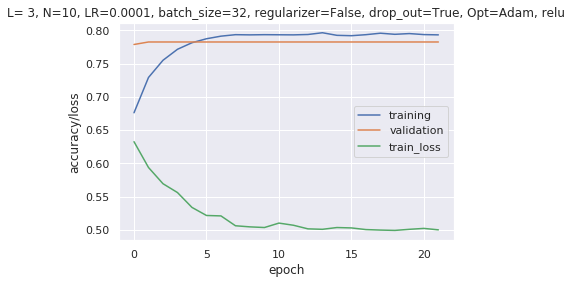

F1_Train = 0.41394422310756973, F1_Test = 0.40927258193445243,
Acc_Train = 0.63225, Acc_Test = 0.6305, Precision=0.30512514898688914, Recall =0.6213592233009708
[[1005  583]
 [ 156  256]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.2402581


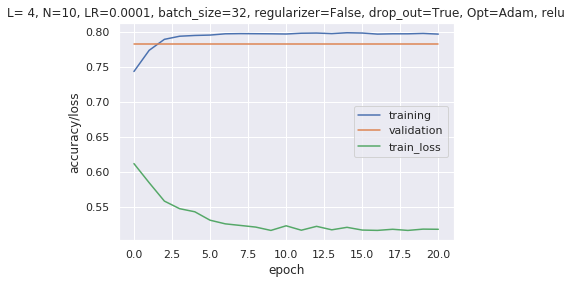

F1_Train = 0.37154737154737155, F1_Test = 0.3666469544648137,
Acc_Train = 0.471, Acc_Test = 0.4645, Precision=0.24237685691946834, Recall =0.7524271844660194
[[619 969]
 [102 310]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.2303097


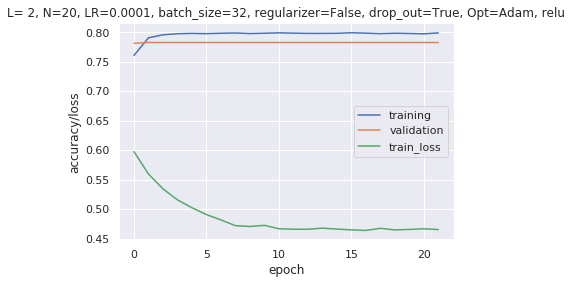

F1_Train = 0.4575079872204473, F1_Test = 0.4234309623430962,
Acc_Train = 0.681625, Acc_Test = 0.6555, Precision=0.3231162196679438, Recall =0.6140776699029126
[[1058  530]
 [ 159  253]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00022: early stopping
optimalTh= 0.28211087


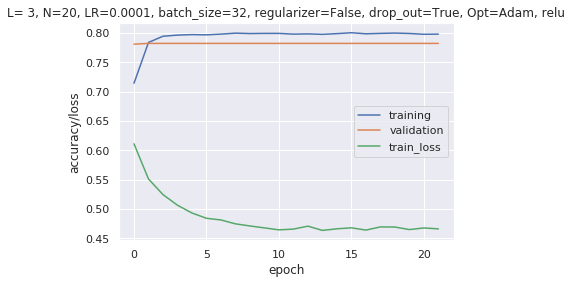

F1_Train = 0.46702870442203265, F1_Test = 0.4867162592986185,
Acc_Train = 0.742375, Acc_Test = 0.7585, Precision=0.43289224952741023, Recall =0.5558252427184466
[[1288  300]
 [ 183  229]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.24808052


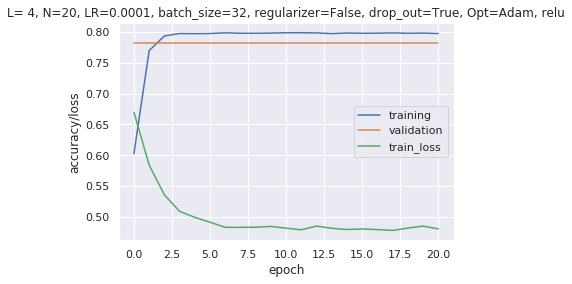

F1_Train = 0.44815588030619347, F1_Test = 0.4386129334582943,
Acc_Train = 0.702625, Acc_Test = 0.7005, Precision=0.35725190839694654, Recall =0.5679611650485437
[[1167  421]
 [ 178  234]]




Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 00058: early stopping
optimalTh= 0.33831054


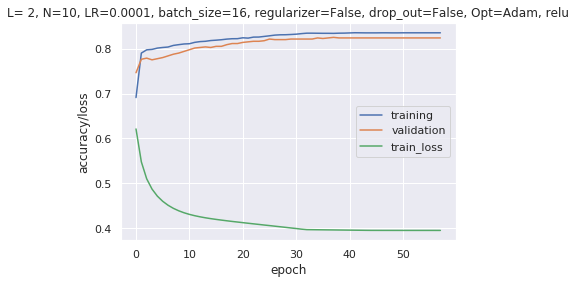

F1_Train = 0.5353788353162179, F1_Test = 0.4981226533166458,
Acc_Train = 0.8145, Acc_Test = 0.7995, Precision=0.5142118863049095, Recall =0.4830097087378641
[[1400  188]
 [ 213  199]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.2076863


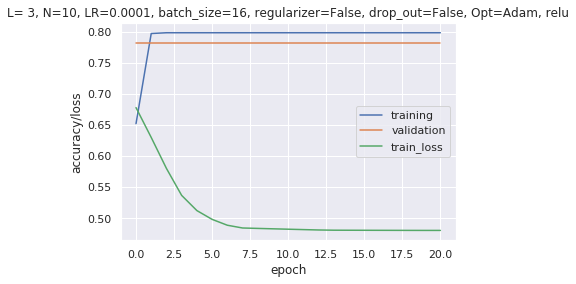

F1_Train = 0.3913644214162349, F1_Test = 0.37777777777777777,
Acc_Train = 0.5595, Acc_Test = 0.552, Precision=0.26459143968871596, Recall =0.6601941747572816
[[832 756]
 [140 272]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.2532189


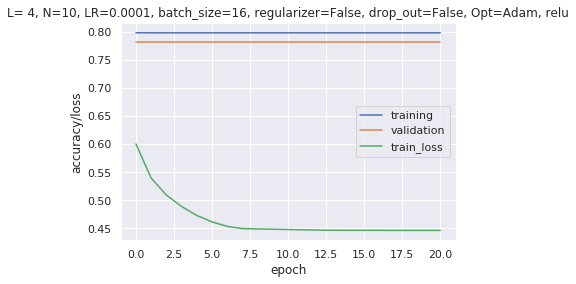

F1_Train = 0.47266035751840163, F1_Test = 0.46284501061571126,
Acc_Train = 0.74925, Acc_Test = 0.747, Precision=0.41132075471698115, Recall =0.529126213592233
[[1276  312]
 [ 194  218]]




Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00076: early stopping
optimalTh= 0.3354851


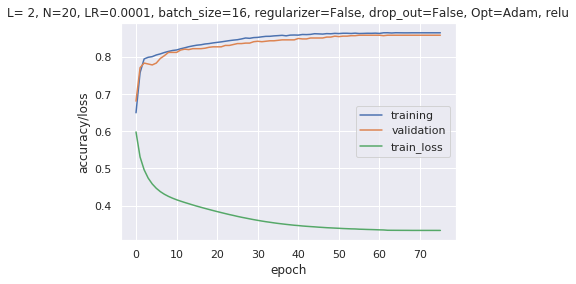

F1_Train = 0.6227217496962333, F1_Test = 0.6024691358024691,
Acc_Train = 0.84475, Acc_Test = 0.839, Precision=0.6130653266331658, Recall =0.5922330097087378
[[1434  154]
 [ 168  244]]




Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00058: early stopping
optimalTh= 0.30940503


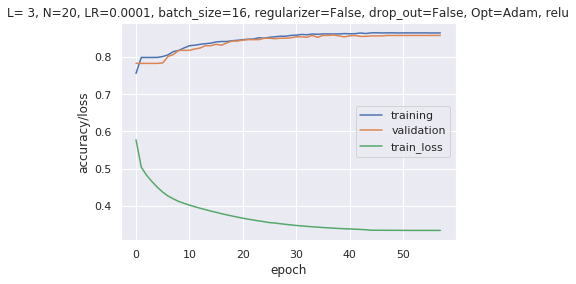

F1_Train = 0.6246001744693225, F1_Test = 0.5928571428571429,
Acc_Train = 0.838625, Acc_Test = 0.829, Precision=0.5817757009345794, Recall =0.6043689320388349
[[1409  179]
 [ 163  249]]




Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00043: early stopping
optimalTh= 0.29280615


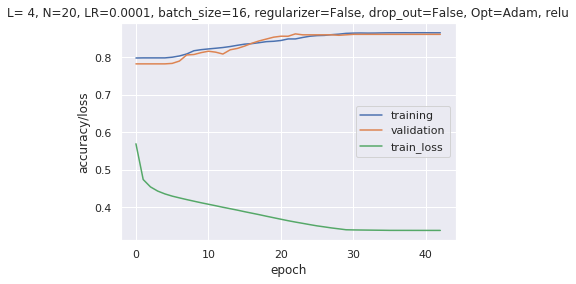

F1_Train = 0.6198898231371411, F1_Test = 0.5869565217391305,
Acc_Train = 0.836125, Acc_Test = 0.829, Precision=0.5841346153846154, Recall =0.5898058252427184
[[1415  173]
 [ 169  243]]




Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00064: early stopping
optimalTh= 0.31418523


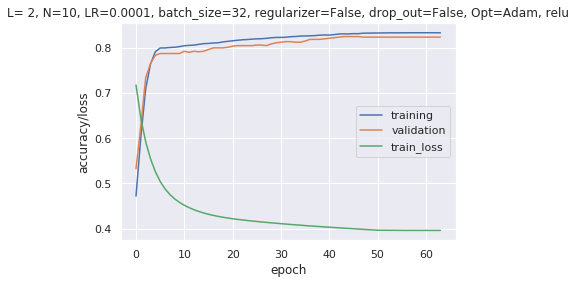

F1_Train = 0.5423122765196663, F1_Test = 0.5330132052821128,
Acc_Train = 0.808, Acc_Test = 0.8055, Precision=0.5273159144893111, Recall =0.5388349514563107
[[1389  199]
 [ 190  222]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.23518485


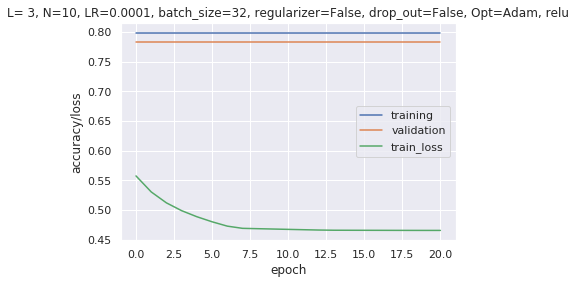

F1_Train = 0.4161504932323927, F1_Test = 0.41750227894257064,
Acc_Train = 0.681875, Acc_Test = 0.6805, Precision=0.3343065693430657, Recall =0.5558252427184466
[[1132  456]
 [ 183  229]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.18608534


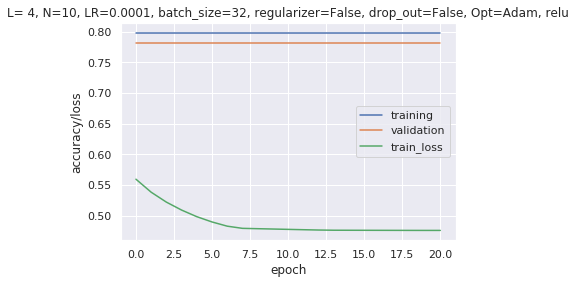

F1_Train = 0.39609582963620227, F1_Test = 0.3750894774516822,
Acc_Train = 0.574625, Acc_Test = 0.5635, Precision=0.265989847715736, Recall =0.6359223300970874
[[865 723]
 [150 262]]




Epoch 00067: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00081: early stopping
optimalTh= 0.36530763


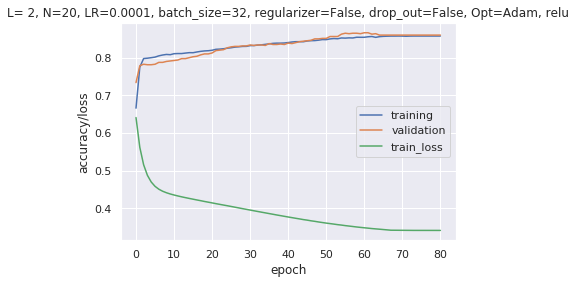

F1_Train = 0.6246786632390746, F1_Test = 0.5894465894465896,
Acc_Train = 0.854, Acc_Test = 0.8405, Precision=0.6273972602739726, Recall =0.5558252427184466
[[1452  136]
 [ 183  229]]




Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 00056: early stopping
optimalTh= 0.27263823


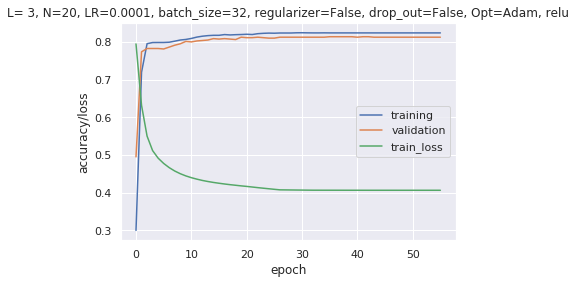

F1_Train = 0.5261472785485591, F1_Test = 0.49092849519743864,
Acc_Train = 0.778, Acc_Test = 0.7615, Precision=0.4380952380952381, Recall =0.558252427184466
[[1293  295]
 [ 182  230]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00021: early stopping
optimalTh= 0.20222089


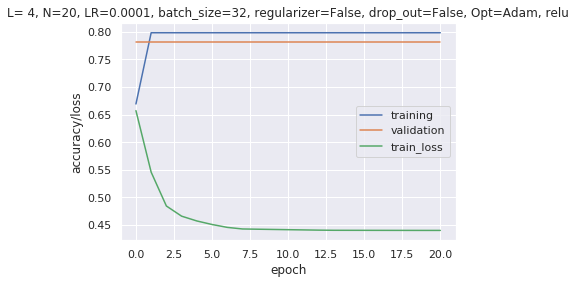

F1_Train = 0.47829716193656097, F1_Test = 0.46476510067114096,
Acc_Train = 0.6875, Acc_Test = 0.681, Precision=0.35512820512820514, Recall =0.6723300970873787
[[1085  503]
 [ 135  277]]




Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00036: early stopping
optimalTh= 0.31439433


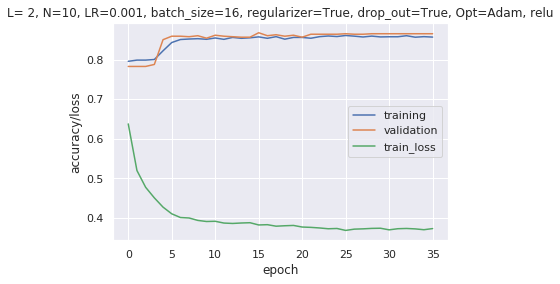

F1_Train = 0.6295736316903539, F1_Test = 0.6109725685785535,
Acc_Train = 0.846875, Acc_Test = 0.844, Precision=0.6282051282051282, Recall =0.5946601941747572
[[1443  145]
 [ 167  245]]




Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00051: early stopping
optimalTh= 0.32057476


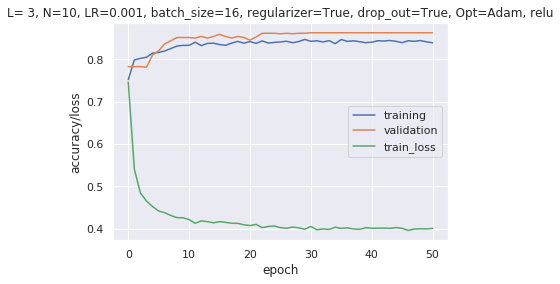

F1_Train = 0.6246507295870848, F1_Test = 0.5942571785268415,
Acc_Train = 0.848875, Acc_Test = 0.8375, Precision=0.6118251928020566, Recall =0.5776699029126213
[[1437  151]
 [ 174  238]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00021: early stopping
optimalTh= 0.24159384


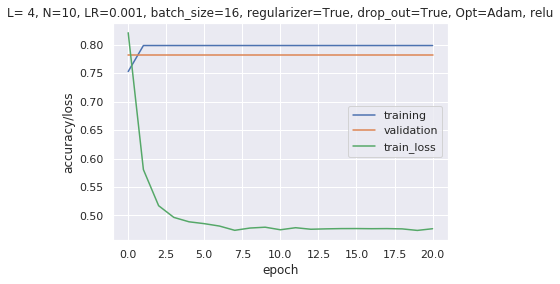

F1_Train = 0.5165179647938268, F1_Test = 0.4962121212121212,
Acc_Train = 0.749375, Acc_Test = 0.734, Precision=0.40683229813664595, Recall =0.6359223300970874
[[1206  382]
 [ 150  262]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00028: early stopping
optimalTh= 0.3425535


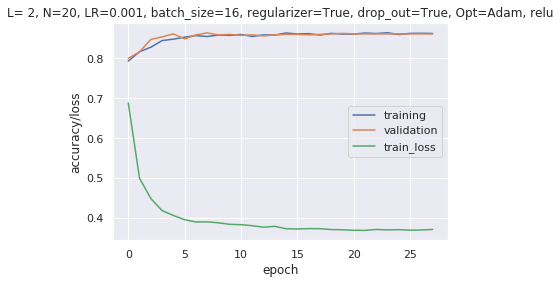

F1_Train = 0.6268656716417911, F1_Test = 0.5894465894465896,
Acc_Train = 0.853125, Acc_Test = 0.8405, Precision=0.6273972602739726, Recall =0.5558252427184466
[[1452  136]
 [ 183  229]]




Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00029: early stopping
optimalTh= 0.3367324


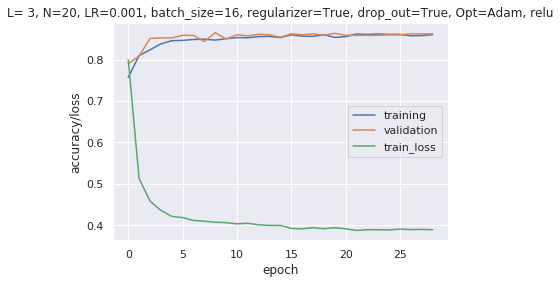

F1_Train = 0.6277742549143944, F1_Test = 0.6041131105398458,
Acc_Train = 0.85325, Acc_Test = 0.846, Precision=0.6420765027322405, Recall =0.5703883495145631
[[1457  131]
 [ 177  235]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00028: early stopping
optimalTh= 0.31663522


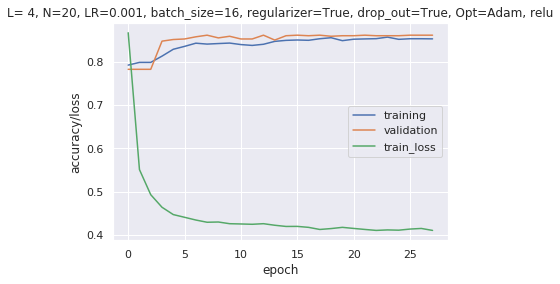

F1_Train = 0.6230936819172114, F1_Test = 0.5972396486825596,
Acc_Train = 0.848625, Acc_Test = 0.8395, Precision=0.6181818181818182, Recall =0.5776699029126213
[[1441  147]
 [ 174  238]]




Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00040: early stopping
optimalTh= 0.3523723


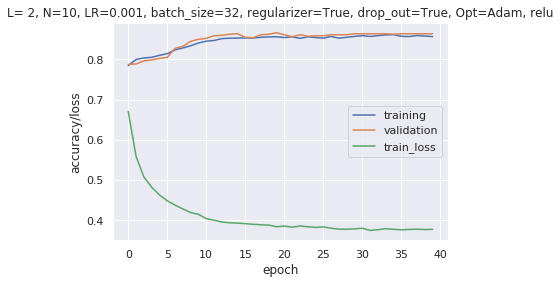

F1_Train = 0.6226537216828479, F1_Test = 0.5854304635761588,
Acc_Train = 0.85425, Acc_Test = 0.8435, Precision=0.6443148688046647, Recall =0.5364077669902912
[[1466  122]
 [ 191  221]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00055: early stopping
optimalTh= 0.26640192


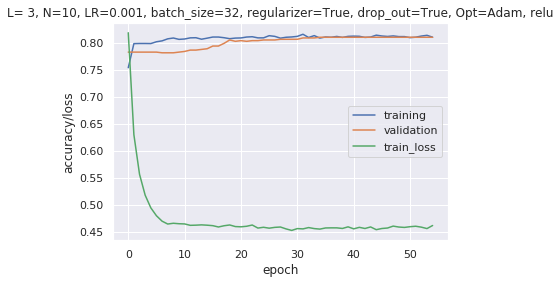

F1_Train = 0.5265392781316348, F1_Test = 0.5121180189673341,
Acc_Train = 0.777, Acc_Test = 0.7685, Precision=0.45251396648044695, Recall =0.5898058252427184
[[1294  294]
 [ 169  243]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00021: early stopping
optimalTh= 0.2656328


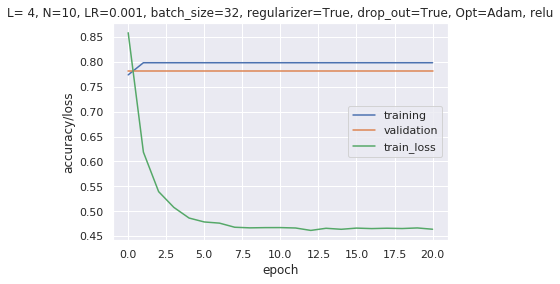

F1_Train = 0.5572755417956656, F1_Test = 0.5341488277268095,
Acc_Train = 0.7855, Acc_Test = 0.7715, Precision=0.46045694200351495, Recall =0.6359223300970874
[[1281  307]
 [ 150  262]]




Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00030: early stopping
optimalTh= 0.3894906


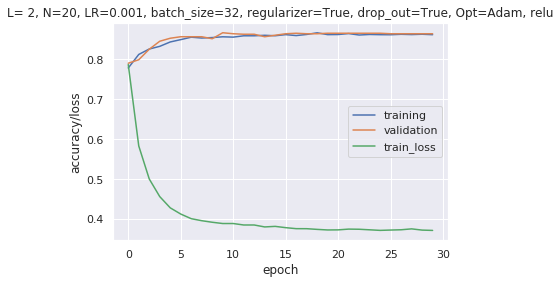

F1_Train = 0.6238594119635011, F1_Test = 0.5773480662983426,
Acc_Train = 0.860875, Acc_Test = 0.847, Precision=0.6698717948717948, Recall =0.5072815533980582
[[1485  103]
 [ 203  209]]




Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00031: early stopping
optimalTh= 0.30820826


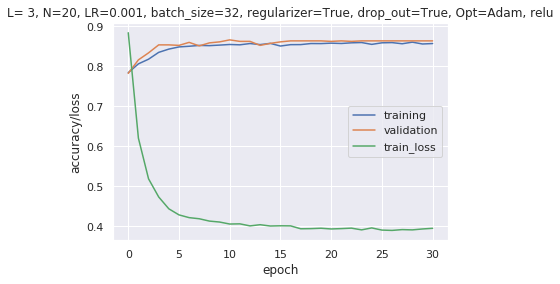

F1_Train = 0.6290030211480362, F1_Test = 0.6076260762607626,
Acc_Train = 0.8465, Acc_Test = 0.8405, Precision=0.6159600997506235, Recall =0.5995145631067961
[[1434  154]
 [ 165  247]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00021: early stopping
optimalTh= 0.3213237


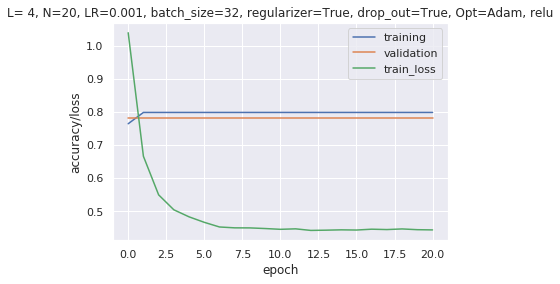

F1_Train = 0.601311270683734, F1_Test = 0.5645569620253164,
Acc_Train = 0.840375, Acc_Test = 0.828, Precision=0.58994708994709, Recall =0.5412621359223301
[[1433  155]
 [ 189  223]]




Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00033: early stopping
optimalTh= 0.32097417


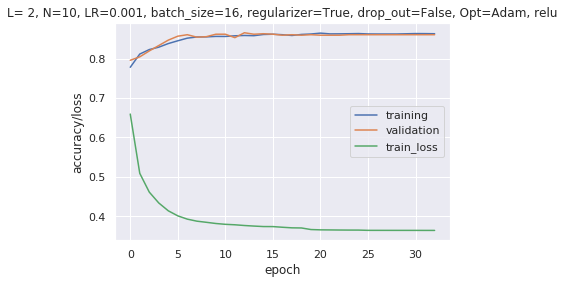

F1_Train = 0.6235186873290793, F1_Test = 0.59727385377943,
Acc_Train = 0.845125, Acc_Test = 0.8375, Precision=0.610126582278481, Recall =0.5849514563106796
[[1434  154]
 [ 171  241]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00039: early stopping
optimalTh= 0.34756425


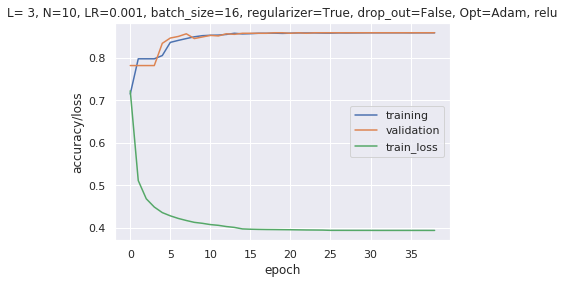

F1_Train = 0.6184554973821991, F1_Test = 0.5918097754293263,
Acc_Train = 0.85425, Acc_Test = 0.8455, Precision=0.6492753623188405, Recall =0.5436893203883495
[[1467  121]
 [ 188  224]]




Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00031: early stopping
optimalTh= 0.3349267


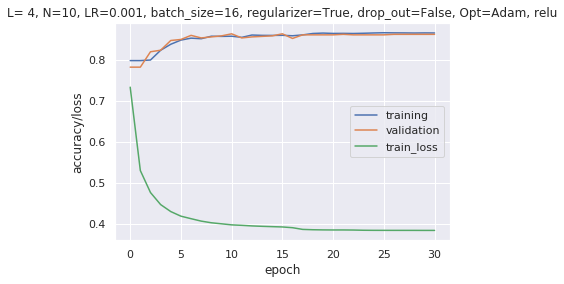

F1_Train = 0.6187270501835985, F1_Test = 0.6022584692597239,
Acc_Train = 0.84425, Acc_Test = 0.8415, Precision=0.6233766233766234, Recall =0.5825242718446602
[[1443  145]
 [ 172  240]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00028: early stopping
optimalTh= 0.38074702


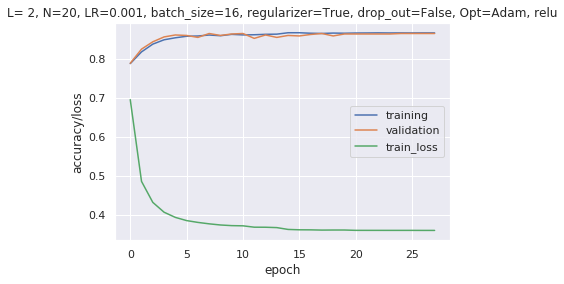

F1_Train = 0.627113026184952, F1_Test = 0.5880758807588076,
Acc_Train = 0.859375, Acc_Test = 0.848, Precision=0.6656441717791411, Recall =0.5266990291262136
[[1479  109]
 [ 195  217]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00027: early stopping
optimalTh= 0.33018854


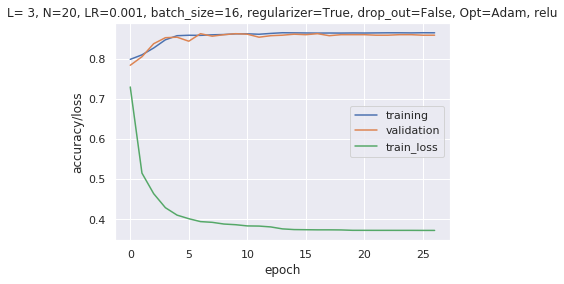

F1_Train = 0.6282011724776304, F1_Test = 0.6045340050377834,
Acc_Train = 0.849375, Acc_Test = 0.843, Precision=0.6282722513089005, Recall =0.5825242718446602
[[1446  142]
 [ 172  240]]




Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00037: early stopping
optimalTh= 0.3274687


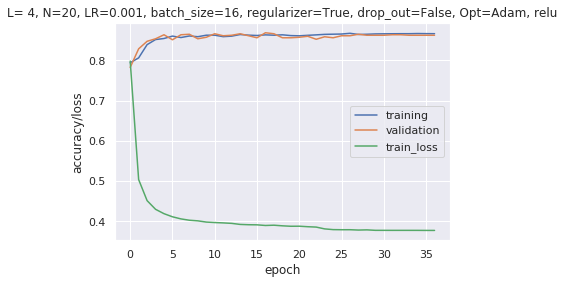

F1_Train = 0.6323170731707317, F1_Test = 0.6151930261519303,
Acc_Train = 0.84925, Acc_Test = 0.8455, Precision=0.6317135549872123, Recall =0.5995145631067961
[[1444  144]
 [ 165  247]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00042: early stopping
optimalTh= 0.2660604


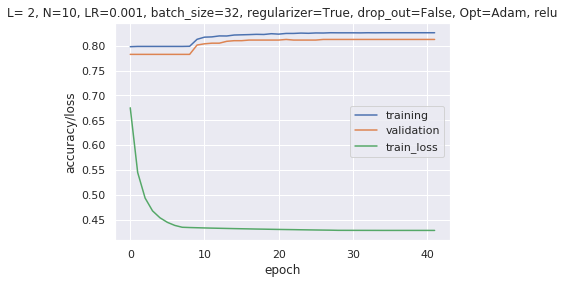

F1_Train = 0.5221569674319273, F1_Test = 0.5187566988210075,
Acc_Train = 0.77625, Acc_Test = 0.7755, Precision=0.46449136276391556, Recall =0.587378640776699
[[1309  279]
 [ 170  242]]




Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00039: early stopping
optimalTh= 0.34755188


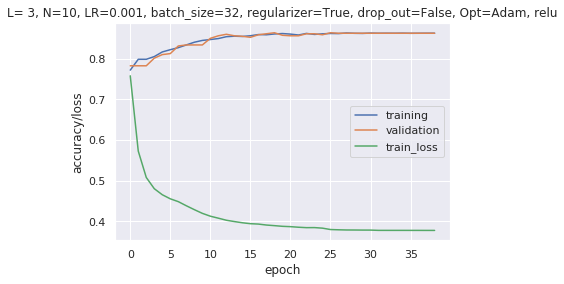

F1_Train = 0.6238589864652186, F1_Test = 0.5905006418485237,
Acc_Train = 0.850625, Acc_Test = 0.8405, Precision=0.6267029972752044, Recall =0.558252427184466
[[1451  137]
 [ 182  230]]




Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00048: early stopping
optimalTh= 0.3098453


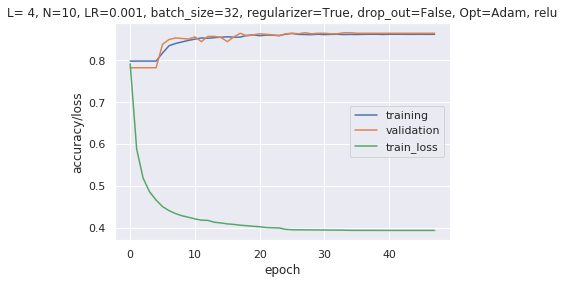

F1_Train = 0.623069936421435, F1_Test = 0.6007326007326007,
Acc_Train = 0.844375, Acc_Test = 0.8365, Precision=0.6044226044226044, Recall =0.5970873786407767
[[1427  161]
 [ 166  246]]




Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00033: early stopping
optimalTh= 0.3312117


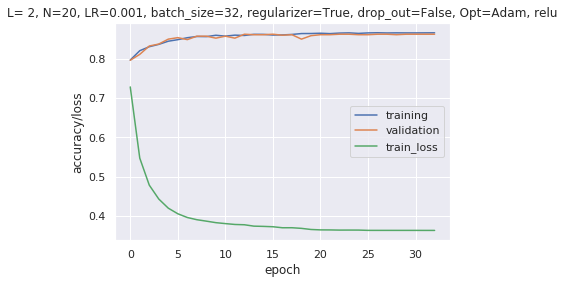

F1_Train = 0.6256914566687155, F1_Test = 0.605,
Acc_Train = 0.84775, Acc_Test = 0.842, Precision=0.6237113402061856, Recall =0.587378640776699
[[1442  146]
 [ 170  242]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00035: early stopping
optimalTh= 0.34594882


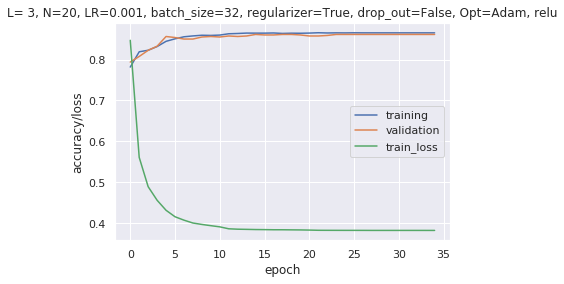

F1_Train = 0.6225755166931638, F1_Test = 0.5891472868217054,
Acc_Train = 0.851625, Acc_Test = 0.841, Precision=0.6298342541436464, Recall =0.5533980582524272
[[1454  134]
 [ 184  228]]




Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00042: early stopping
optimalTh= 0.3129747


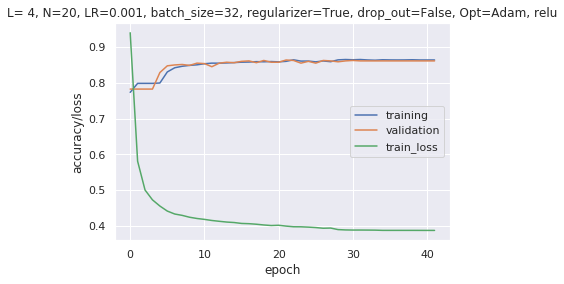

F1_Train = 0.628657616892911, F1_Test = 0.6133004926108374,
Acc_Train = 0.846125, Acc_Test = 0.843, Precision=0.6225, Recall =0.6043689320388349
[[1437  151]
 [ 163  249]]




Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00029: early stopping
optimalTh= 0.30526483


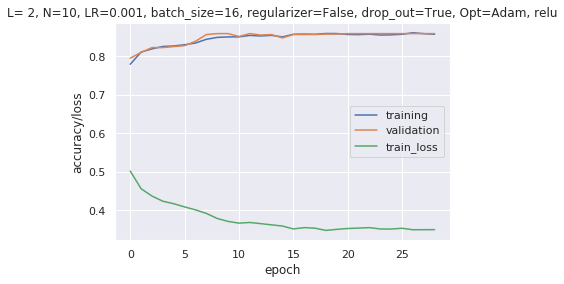

F1_Train = 0.6211562115621155, F1_Test = 0.6007416563658838,
Acc_Train = 0.846, Acc_Test = 0.8385, Precision=0.6120906801007556, Recall =0.5898058252427184
[[1434  154]
 [ 169  243]]




Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00035: early stopping
optimalTh= 0.28207368


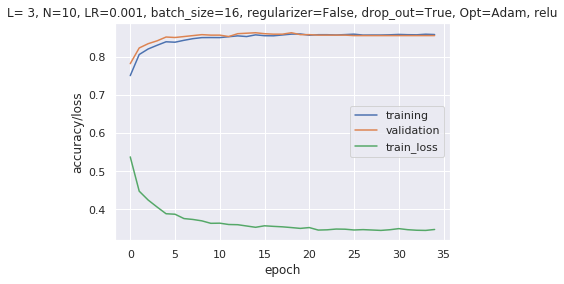

F1_Train = 0.631266686443192, F1_Test = 0.6105006105006104,
Acc_Train = 0.844625, Acc_Test = 0.8405, Precision=0.6142506142506142, Recall =0.6067961165048543
[[1431  157]
 [ 162  250]]




Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00036: early stopping
optimalTh= 0.3065645


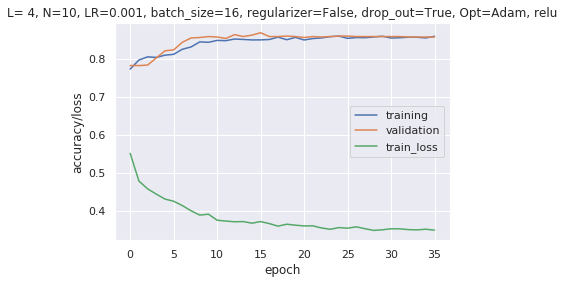

F1_Train = 0.6451022276472383, F1_Test = 0.5960591133004925,
Acc_Train = 0.854625, Acc_Test = 0.836, Precision=0.605, Recall =0.587378640776699
[[1430  158]
 [ 170  242]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00028: early stopping
optimalTh= 0.35251248


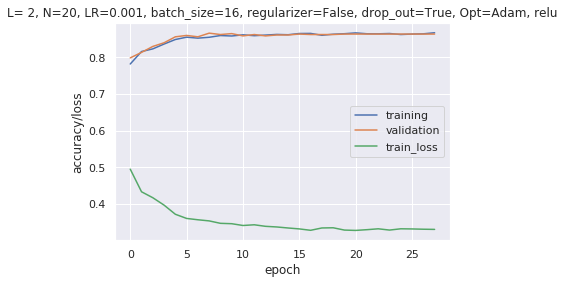

F1_Train = 0.6395906619763353, F1_Test = 0.609724047306176,
Acc_Train = 0.859125, Acc_Test = 0.8515, Precision=0.664756446991404, Recall =0.5631067961165048
[[1471  117]
 [ 180  232]]




Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00029: early stopping
optimalTh= 0.29677373


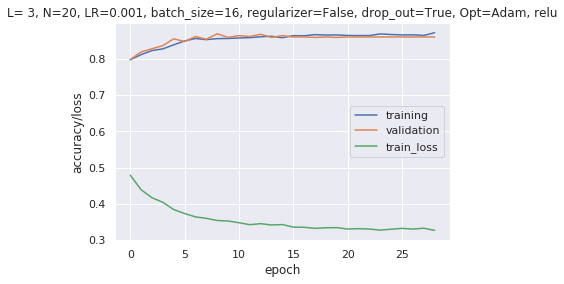

F1_Train = 0.6444715943799634, F1_Test = 0.5866336633663367,
Acc_Train = 0.8545, Acc_Test = 0.833, Precision=0.5984848484848485, Recall =0.5752427184466019
[[1429  159]
 [ 175  237]]




Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00041: early stopping
optimalTh= 0.27892578


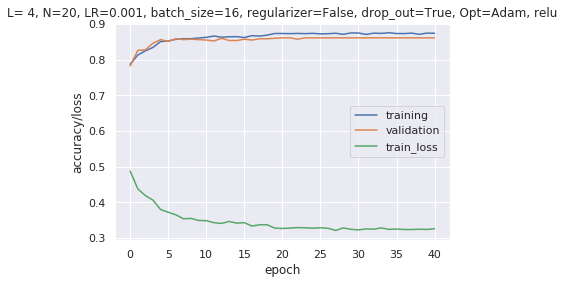

F1_Train = 0.6456984273820536, F1_Test = 0.606826801517067,
Acc_Train = 0.856375, Acc_Test = 0.8445, Precision=0.633245382585752, Recall =0.5825242718446602
[[1449  139]
 [ 172  240]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00032: early stopping
optimalTh= 0.34673566


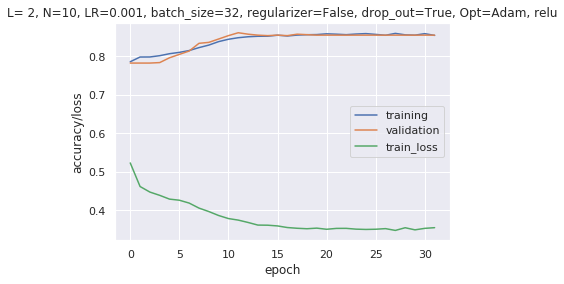

F1_Train = 0.61743264659271, F1_Test = 0.6012738853503184,
Acc_Train = 0.849125, Acc_Test = 0.8435, Precision=0.6327077747989276, Recall =0.5728155339805825
[[1451  137]
 [ 176  236]]




Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00036: early stopping
optimalTh= 0.2730955


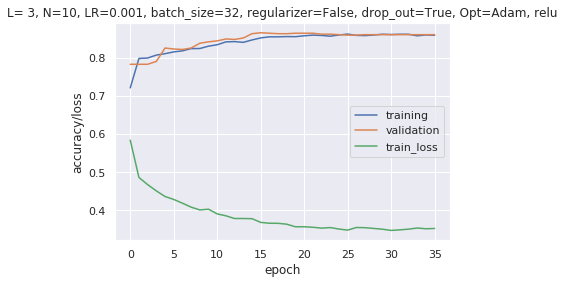

F1_Train = 0.6249254621347645, F1_Test = 0.6167076167076166,
Acc_Train = 0.84275, Acc_Test = 0.844, Precision=0.6243781094527363, Recall =0.6092233009708737
[[1437  151]
 [ 161  251]]




Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00034: early stopping
optimalTh= 0.3180665


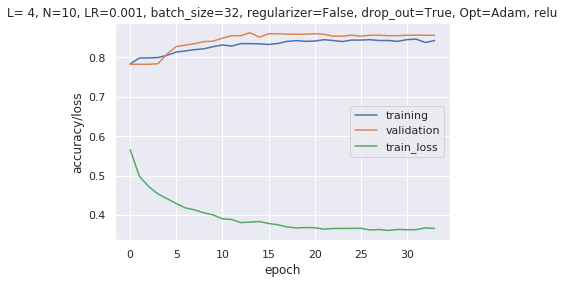

F1_Train = 0.6250820748522652, F1_Test = 0.5964912280701754,
Acc_Train = 0.85725, Acc_Test = 0.8505, Precision=0.6717325227963525, Recall =0.5364077669902912
[[1480  108]
 [ 191  221]]




Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00034: early stopping
optimalTh= 0.3339573


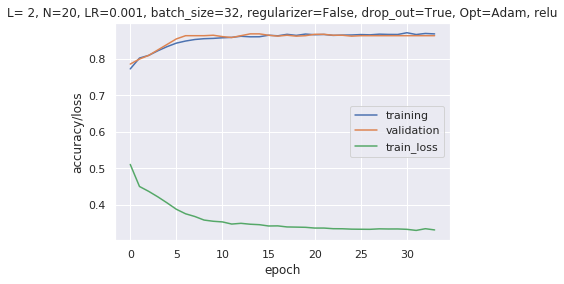

F1_Train = 0.6371120962634579, F1_Test = 0.6106080206985769,
Acc_Train = 0.85675, Acc_Test = 0.8495, Precision=0.6537396121883656, Recall =0.5728155339805825
[[1463  125]
 [ 176  236]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00032: early stopping
optimalTh= 0.33892763


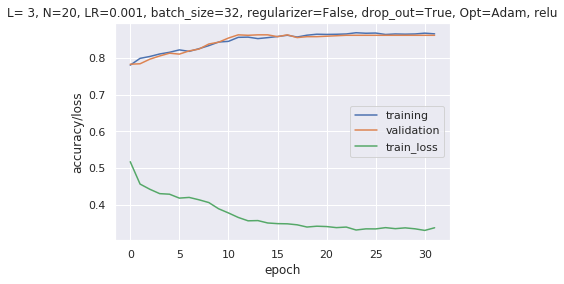

F1_Train = 0.6425309849967383, F1_Test = 0.6119205298013244,
Acc_Train = 0.863, Acc_Test = 0.8535, Precision=0.673469387755102, Recall =0.5606796116504854
[[1476  112]
 [ 181  231]]




Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00030: early stopping
optimalTh= 0.33477718


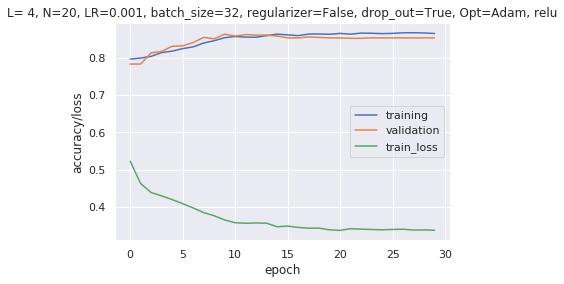

F1_Train = 0.6344050381173351, F1_Test = 0.6034712950600801,
Acc_Train = 0.862125, Acc_Test = 0.8515, Precision=0.6706231454005934, Recall =0.5485436893203883
[[1477  111]
 [ 186  226]]




Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00036: early stopping
optimalTh= 0.32751018


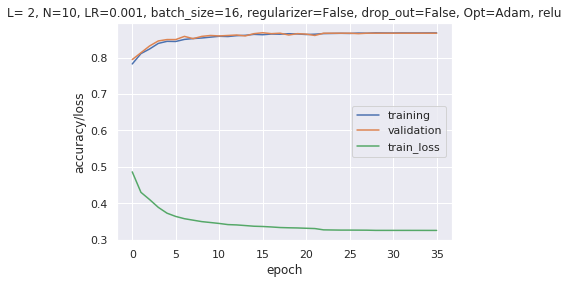

F1_Train = 0.6366739062984796, F1_Test = 0.6040100250626566,
Acc_Train = 0.853625, Acc_Test = 0.842, Precision=0.6243523316062176, Recall =0.5849514563106796
[[1443  145]
 [ 171  241]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00028: early stopping
optimalTh= 0.3258026


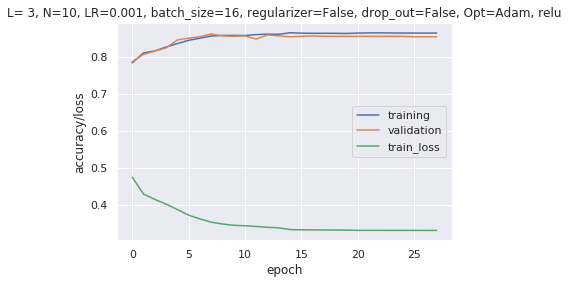

F1_Train = 0.6287605294825511, F1_Test = 0.5980629539951574,
Acc_Train = 0.84575, Acc_Test = 0.834, Precision=0.5966183574879227, Recall =0.5995145631067961
[[1421  167]
 [ 165  247]]




Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00031: early stopping
optimalTh= 0.3199023


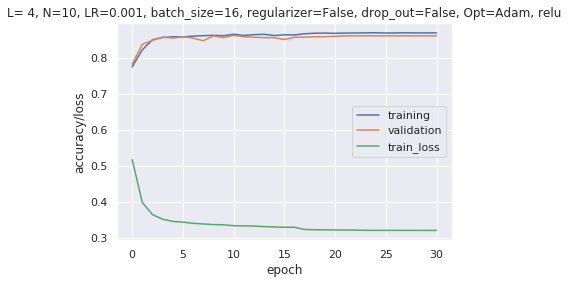

F1_Train = 0.6466073073380412, F1_Test = 0.6110397946084724,
Acc_Train = 0.856125, Acc_Test = 0.8485, Precision=0.6485013623978202, Recall =0.5776699029126213
[[1459  129]
 [ 174  238]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00027: early stopping
optimalTh= 0.2892877


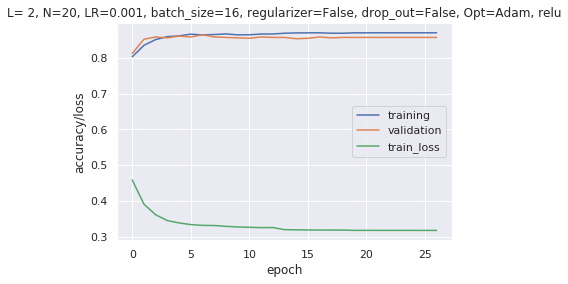

F1_Train = 0.6429398148148149, F1_Test = 0.6177514792899409,
Acc_Train = 0.84575, Acc_Test = 0.8385, Precision=0.6027713625866051, Recall =0.633495145631068
[[1416  172]
 [ 151  261]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00026: early stopping
optimalTh= 0.32215485


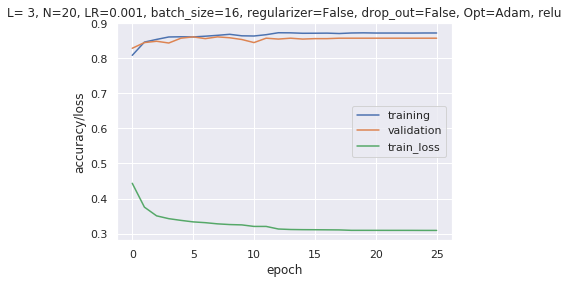

F1_Train = 0.6495623302143073, F1_Test = 0.5936305732484077,
Acc_Train = 0.854875, Acc_Test = 0.8405, Precision=0.6246648793565683, Recall =0.5655339805825242
[[1448  140]
 [ 179  233]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00024: early stopping
optimalTh= 0.31468898


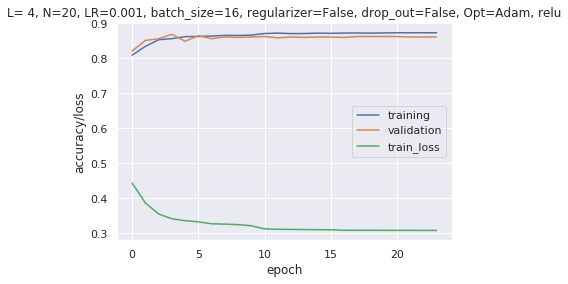

F1_Train = 0.6545012165450121, F1_Test = 0.59727385377943,
Acc_Train = 0.858, Acc_Test = 0.8375, Precision=0.610126582278481, Recall =0.5849514563106796
[[1434  154]
 [ 171  241]]




Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00037: early stopping
optimalTh= 0.34002823


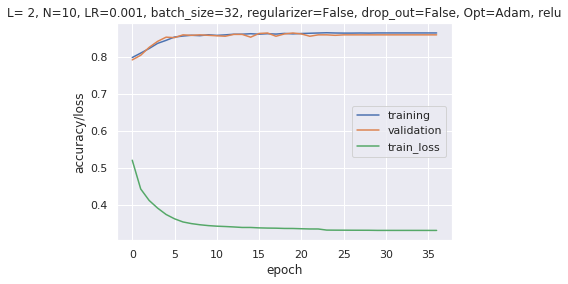

F1_Train = 0.6219624730852046, F1_Test = 0.6118836915297093,
Acc_Train = 0.846375, Acc_Test = 0.8465, Precision=0.6385224274406333, Recall =0.587378640776699
[[1451  137]
 [ 170  242]]




Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00043: early stopping
optimalTh= 0.3051347


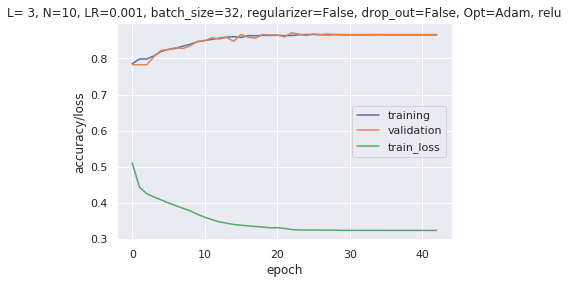

F1_Train = 0.6323226376214307, F1_Test = 0.6002400960384153,
Acc_Train = 0.843875, Acc_Test = 0.8335, Precision=0.5938242280285035, Recall =0.6067961165048543
[[1417  171]
 [ 162  250]]




Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00051: early stopping
optimalTh= 0.30837134


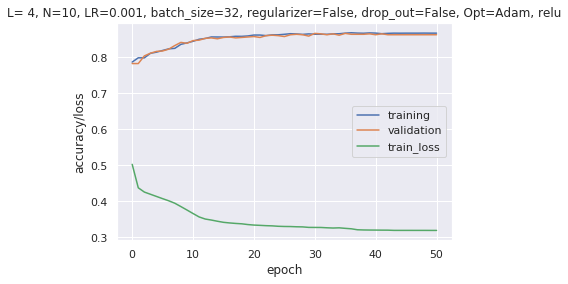

F1_Train = 0.6422018348623852, F1_Test = 0.5857321652065081,
Acc_Train = 0.85375, Acc_Test = 0.8345, Precision=0.6046511627906976, Recall =0.5679611650485437
[[1435  153]
 [ 178  234]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00027: early stopping
optimalTh= 0.28794506


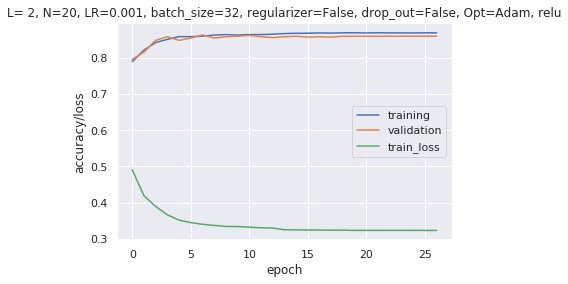

F1_Train = 0.6296918767507003, F1_Test = 0.6102857142857143,
Acc_Train = 0.83475, Acc_Test = 0.8295, Precision=0.5766738660907127, Recall =0.6480582524271845
[[1392  196]
 [ 145  267]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00026: early stopping
optimalTh= 0.2945519


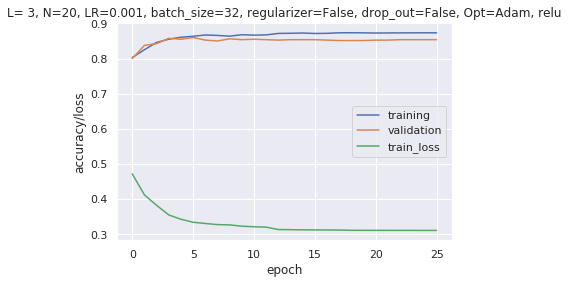

F1_Train = 0.6448377581120944, F1_Test = 0.608904933814681,
Acc_Train = 0.8495, Acc_Test = 0.8375, Precision=0.60381861575179, Recall =0.6140776699029126
[[1422  166]
 [ 159  253]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00027: early stopping
optimalTh= 0.33483693


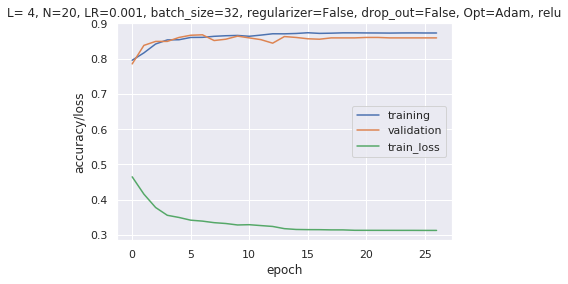

F1_Train = 0.6452016255079712, F1_Test = 0.6104725415070243,
Acc_Train = 0.858125, Acc_Test = 0.8475, Precision=0.6442048517520216, Recall =0.5800970873786407
[[1456  132]
 [ 173  239]]




Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00047: early stopping
optimalTh= 0.344836


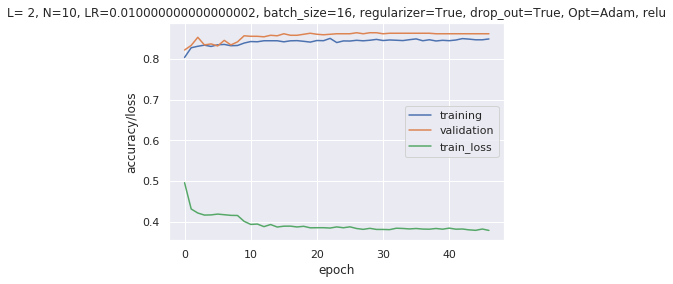

F1_Train = 0.6222364626722203, F1_Test = 0.5796344647519582,
Acc_Train = 0.852625, Acc_Test = 0.839, Precision=0.6271186440677966, Recall =0.5388349514563107
[[1456  132]
 [ 190  222]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00021: early stopping
optimalTh= 0.33014038


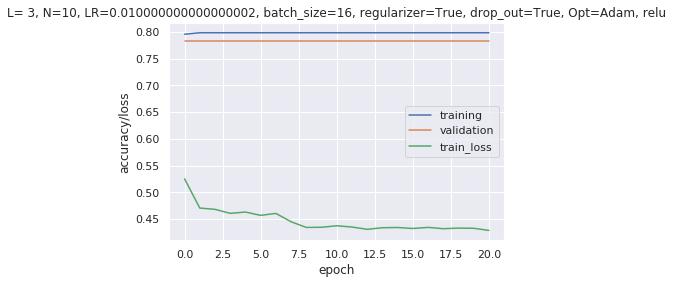

F1_Train = 0.5939429579535431, F1_Test = 0.5625744934445769,
Acc_Train = 0.827375, Acc_Test = 0.8165, Precision=0.5526932084309133, Recall =0.5728155339805825
[[1397  191]
 [ 176  236]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00021: early stopping
optimalTh= 0.25299814


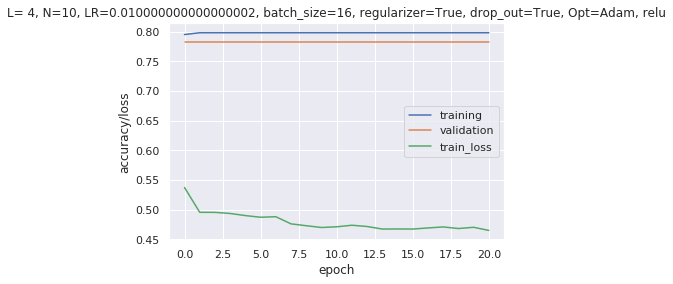

F1_Train = 0.5172670807453416, F1_Test = 0.5078125000000001,
Acc_Train = 0.757125, Acc_Test = 0.748, Precision=0.42483660130718953, Recall =0.6310679611650486
[[1236  352]
 [ 152  260]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00041: early stopping
optimalTh= 0.3362345


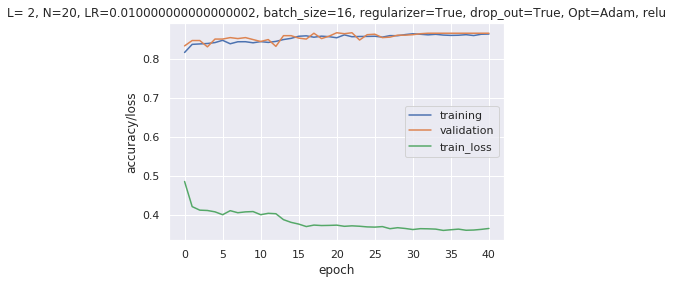

F1_Train = 0.6332070707070707, F1_Test = 0.6056701030927835,
Acc_Train = 0.85475, Acc_Test = 0.847, Precision=0.6456043956043956, Recall =0.5703883495145631
[[1459  129]
 [ 177  235]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00057: early stopping
optimalTh= 0.34713125


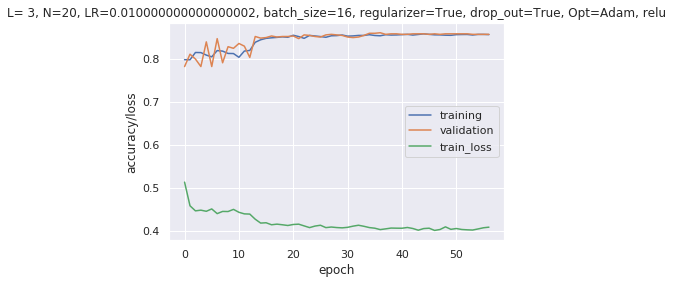

F1_Train = 0.615774469433006, F1_Test = 0.5787451984635084,
Acc_Train = 0.848375, Acc_Test = 0.8355, Precision=0.6124661246612466, Recall =0.5485436893203883
[[1445  143]
 [ 186  226]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00045: early stopping
optimalTh= 0.35203725


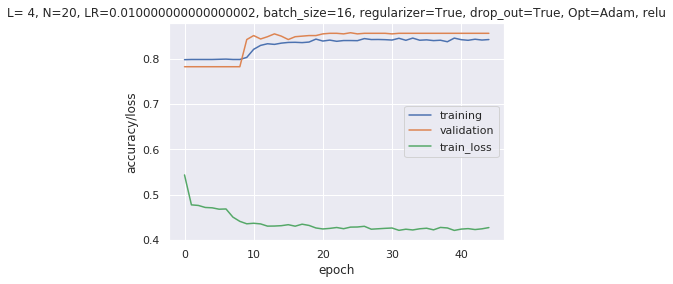

F1_Train = 0.6154340836012862, F1_Test = 0.5725388601036269,
Acc_Train = 0.8505, Acc_Test = 0.835, Precision=0.6138888888888889, Recall =0.5364077669902912
[[1449  139]
 [ 191  221]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00038: early stopping
optimalTh= 0.33490312


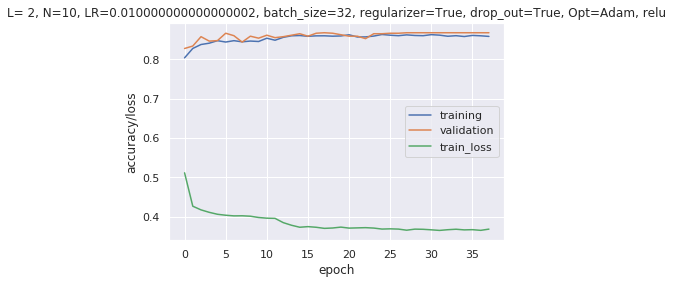

F1_Train = 0.6307498424700694, F1_Test = 0.6020671834625323,
Acc_Train = 0.8535, Acc_Test = 0.846, Precision=0.643646408839779, Recall =0.5655339805825242
[[1459  129]
 [ 179  233]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00052: early stopping
optimalTh= 0.33844945


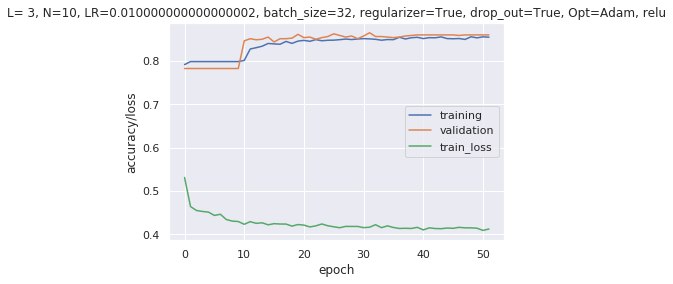

F1_Train = 0.6204055766793409, F1_Test = 0.5917312661498707,
Acc_Train = 0.85025, Acc_Test = 0.842, Precision=0.6325966850828729, Recall =0.5558252427184466
[[1455  133]
 [ 183  229]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00021: early stopping
optimalTh= 0.3320921


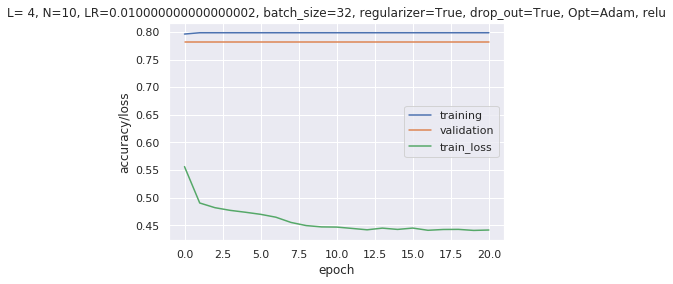

F1_Train = 0.5999384046812442, F1_Test = 0.5607940446650124,
Acc_Train = 0.837625, Acc_Test = 0.823, Precision=0.5736040609137056, Recall =0.5485436893203883
[[1420  168]
 [ 186  226]]




Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00044: early stopping
optimalTh= 0.3372183


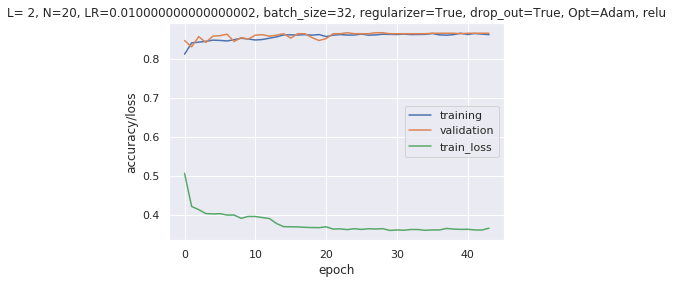

F1_Train = 0.6327364121897581, F1_Test = 0.6023166023166023,
Acc_Train = 0.853875, Acc_Test = 0.8455, Precision=0.6410958904109589, Recall =0.5679611650485437
[[1457  131]
 [ 178  234]]




Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00046: early stopping
optimalTh= 0.36434686


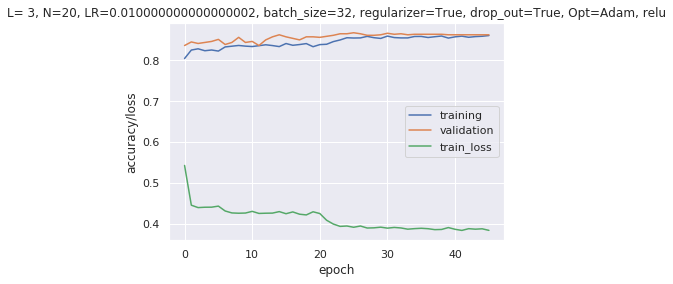

F1_Train = 0.6303069888961462, F1_Test = 0.5879194630872484,
Acc_Train = 0.8585, Acc_Test = 0.8465, Precision=0.6576576576576577, Recall =0.5315533980582524
[[1474  114]
 [ 193  219]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00033: early stopping
optimalTh= 0.35028386


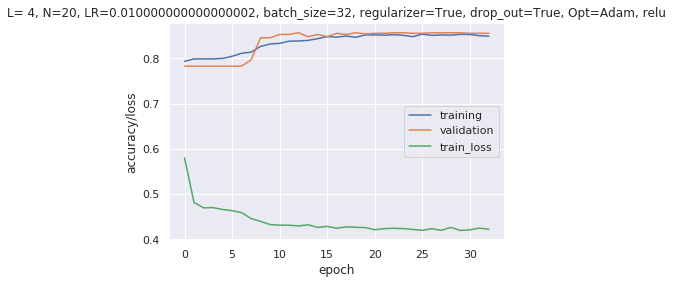

F1_Train = 0.6120606256046437, F1_Test = 0.5729032258064516,
Acc_Train = 0.849625, Acc_Test = 0.8345, Precision=0.6115702479338843, Recall =0.5388349514563107
[[1447  141]
 [ 190  222]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00042: early stopping
optimalTh= 0.36619377


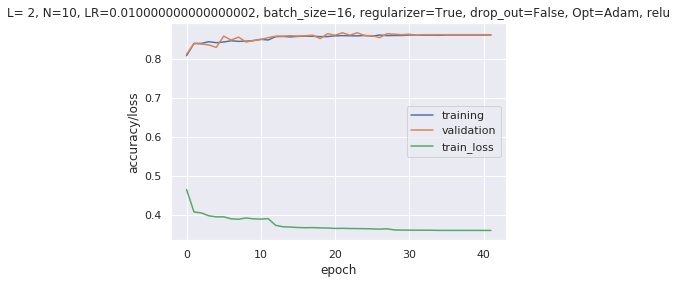

F1_Train = 0.6234527687296417, F1_Test = 0.5793650793650794,
Acc_Train = 0.8555, Acc_Test = 0.841, Precision=0.6366279069767442, Recall =0.5315533980582524
[[1463  125]
 [ 193  219]]




Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00030: early stopping
optimalTh= 0.35460138


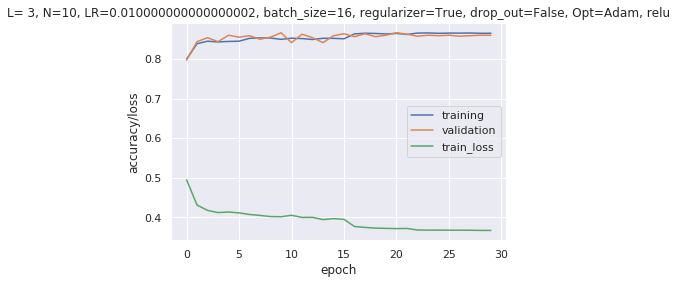

F1_Train = 0.6282457251424953, F1_Test = 0.5945241199478488,
Acc_Train = 0.85325, Acc_Test = 0.8445, Precision=0.6422535211267606, Recall =0.5533980582524272
[[1461  127]
 [ 184  228]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00050: early stopping
optimalTh= 0.30713555


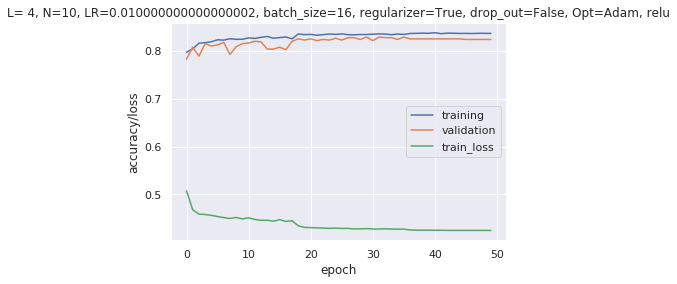

F1_Train = 0.5362142422398053, F1_Test = 0.5217391304347826,
Acc_Train = 0.8095, Acc_Test = 0.8075, Precision=0.5343511450381679, Recall =0.5097087378640777
[[1405  183]
 [ 202  210]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00045: early stopping
optimalTh= 0.3481046


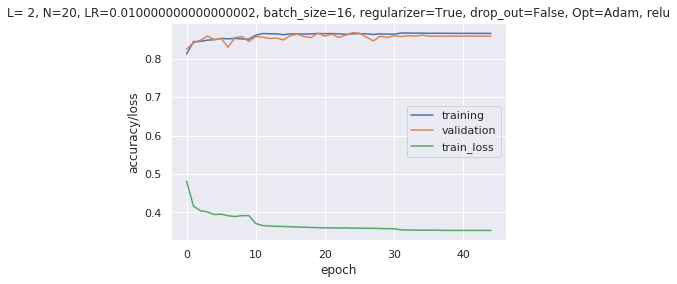

F1_Train = 0.6296992481203009, F1_Test = 0.5968992248062016,
Acc_Train = 0.85225, Acc_Test = 0.844, Precision=0.638121546961326, Recall =0.5606796116504854
[[1457  131]
 [ 181  231]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00039: early stopping
optimalTh= 0.3527555


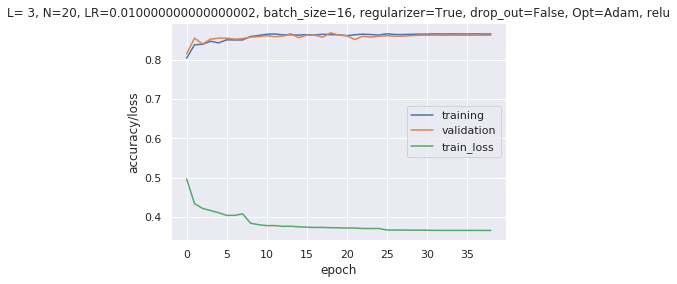

F1_Train = 0.6299713649379574, F1_Test = 0.5953002610966057,
Acc_Train = 0.854625, Acc_Test = 0.845, Precision=0.6440677966101694, Recall =0.5533980582524272
[[1462  126]
 [ 184  228]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00035: early stopping
optimalTh= 0.3470839


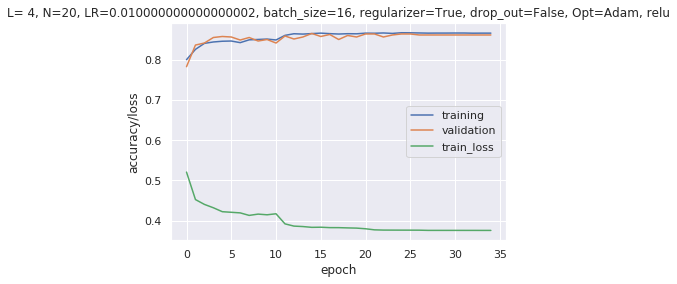

F1_Train = 0.6304552590266875, F1_Test = 0.5997425997425997,
Acc_Train = 0.852875, Acc_Test = 0.8445, Precision=0.6383561643835617, Recall =0.5655339805825242
[[1456  132]
 [ 179  233]]




Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00029: early stopping
optimalTh= 0.31291467


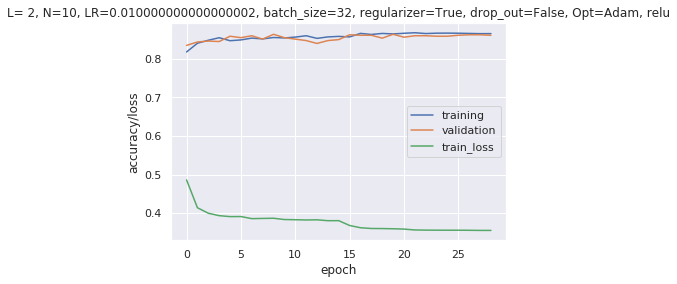

F1_Train = 0.6324228028503563, F1_Test = 0.6084848484848484,
Acc_Train = 0.84525, Acc_Test = 0.8385, Precision=0.6077481840193705, Recall =0.6092233009708737
[[1426  162]
 [ 161  251]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00042: early stopping
optimalTh= 0.3454517


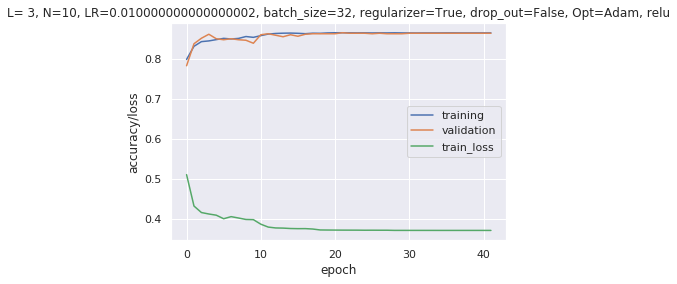

F1_Train = 0.626026531901453, F1_Test = 0.6,
Acc_Train = 0.852, Acc_Test = 0.846, Precision=0.6452513966480447, Recall =0.5606796116504854
[[1461  127]
 [ 181  231]]




Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00040: early stopping
optimalTh= 0.34499693


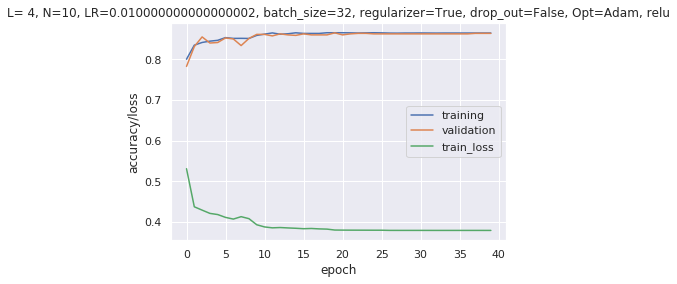

F1_Train = 0.6296179349542154, F1_Test = 0.5992217898832685,
Acc_Train = 0.853375, Acc_Test = 0.8455, Precision=0.6434540389972145, Recall =0.5606796116504854
[[1460  128]
 [ 181  231]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00035: early stopping
optimalTh= 0.3534898


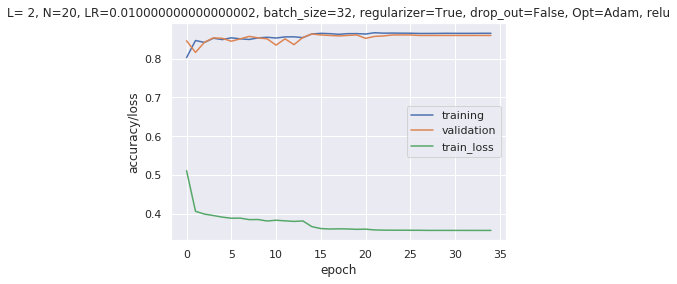

F1_Train = 0.6297229219143577, F1_Test = 0.5911458333333333,
Acc_Train = 0.853, Acc_Test = 0.843, Precision=0.6376404494382022, Recall =0.5509708737864077
[[1459  129]
 [ 185  227]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00032: early stopping
optimalTh= 0.36439332


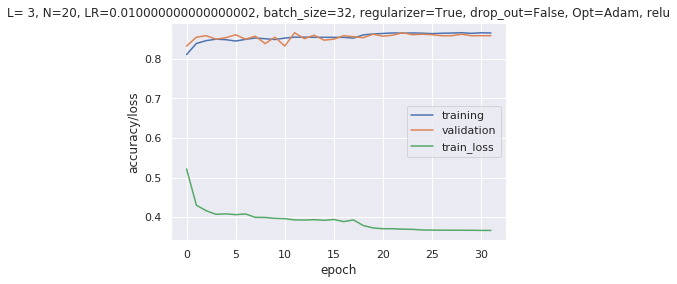

F1_Train = 0.628809752967597, F1_Test = 0.5925925925925926,
Acc_Train = 0.855375, Acc_Test = 0.846, Precision=0.6511627906976745, Recall =0.5436893203883495
[[1468  120]
 [ 188  224]]




Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00034: early stopping
optimalTh= 0.36513868


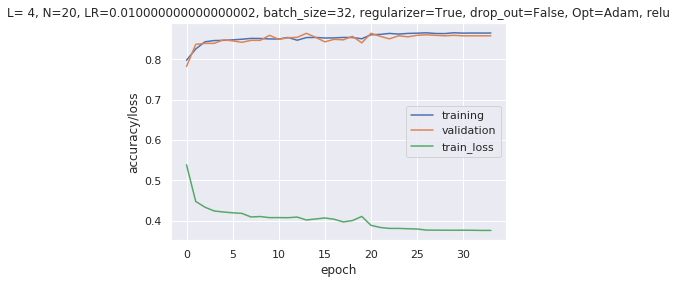

F1_Train = 0.6304277902862656, F1_Test = 0.5936675461741424,
Acc_Train = 0.856375, Acc_Test = 0.846, Precision=0.6502890173410405, Recall =0.5461165048543689
[[1467  121]
 [ 187  225]]




Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00043: early stopping
optimalTh= 0.31407696


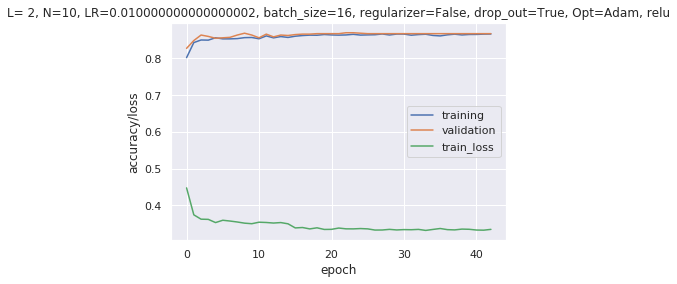

F1_Train = 0.634257748776509, F1_Test = 0.6032171581769437,
Acc_Train = 0.859875, Acc_Test = 0.852, Precision=0.6736526946107785, Recall =0.5461165048543689
[[1479  109]
 [ 187  225]]




Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00031: early stopping
optimalTh= 0.29715955


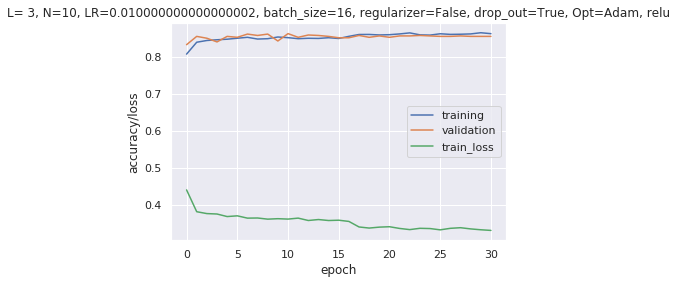

F1_Train = 0.6420756486402001, F1_Test = 0.5982478097622027,
Acc_Train = 0.856875, Acc_Test = 0.8395, Precision=0.6175710594315246, Recall =0.5800970873786407
[[1440  148]
 [ 173  239]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00040: early stopping
optimalTh= 0.27587426


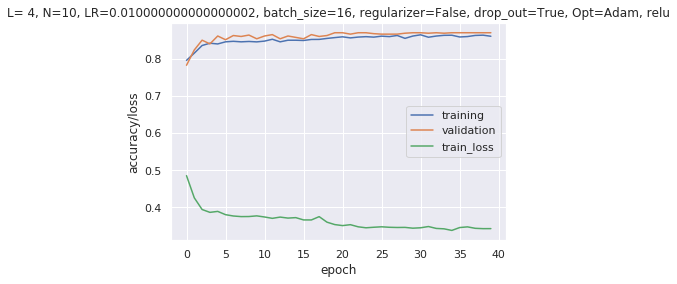

F1_Train = 0.6324409448818896, F1_Test = 0.6,
Acc_Train = 0.854125, Acc_Test = 0.844, Precision=0.6358695652173914, Recall =0.5679611650485437
[[1454  134]
 [ 178  234]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00041: early stopping
optimalTh= 0.3042001


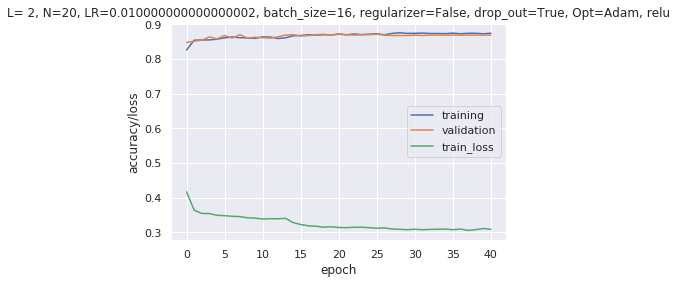

F1_Train = 0.6583629893238434, F1_Test = 0.6122448979591838,
Acc_Train = 0.856, Acc_Test = 0.8385, Precision=0.6057007125890737, Recall =0.6189320388349514
[[1422  166]
 [ 157  255]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00041: early stopping
optimalTh= 0.2721181


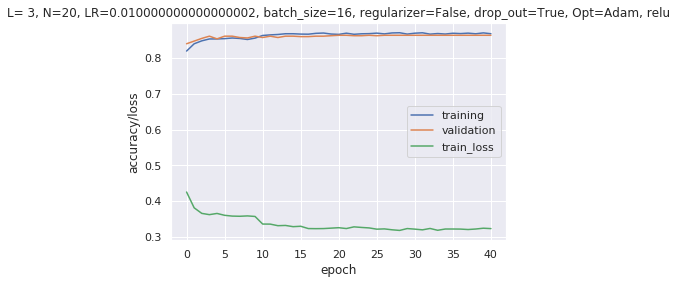

F1_Train = 0.6468085106382979, F1_Test = 0.5985401459854014,
Acc_Train = 0.85475, Acc_Test = 0.835, Precision=0.6, Recall =0.5970873786407767
[[1424  164]
 [ 166  246]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00025: early stopping
optimalTh= 0.28783992


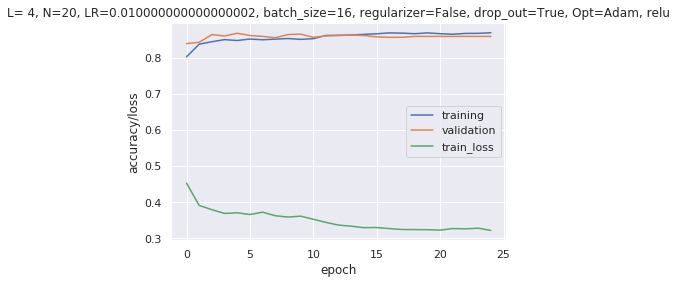

F1_Train = 0.6471277842907387, F1_Test = 0.6068476977567887,
Acc_Train = 0.8495, Acc_Test = 0.8335, Precision=0.5908045977011495, Recall =0.6237864077669902
[[1410  178]
 [ 155  257]]




Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00035: early stopping
optimalTh= 0.30876833


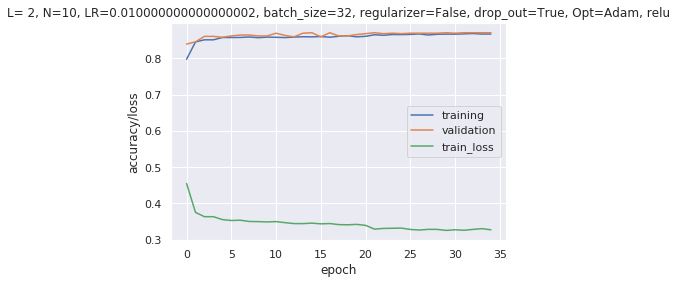

F1_Train = 0.6361614235780108, F1_Test = 0.6053639846743295,
Acc_Train = 0.856875, Acc_Test = 0.8455, Precision=0.6388140161725068, Recall =0.5752427184466019
[[1454  134]
 [ 175  237]]




Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00034: early stopping
optimalTh= 0.30216992


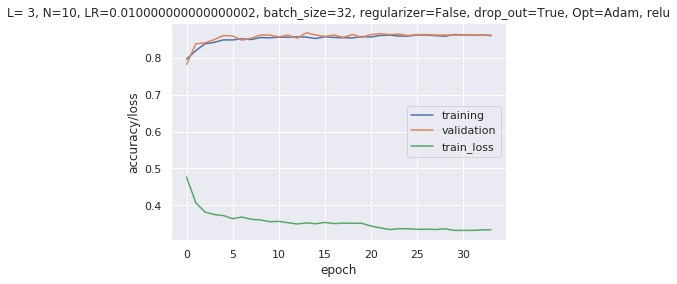

F1_Train = 0.6432498472816127, F1_Test = 0.6050632911392405,
Acc_Train = 0.854, Acc_Test = 0.844, Precision=0.6322751322751323, Recall =0.5800970873786407
[[1449  139]
 [ 173  239]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00042: early stopping
optimalTh= 0.4043622


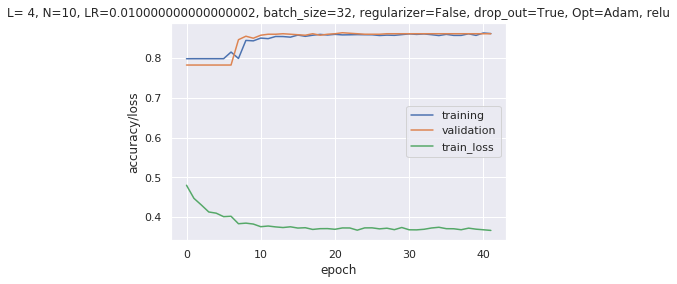

F1_Train = 0.6492699596147872, F1_Test = 0.6060606060606061,
Acc_Train = 0.858875, Acc_Test = 0.844, Precision=0.631578947368421, Recall =0.5825242718446602
[[1448  140]
 [ 172  240]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00040: early stopping
optimalTh= 0.30761907


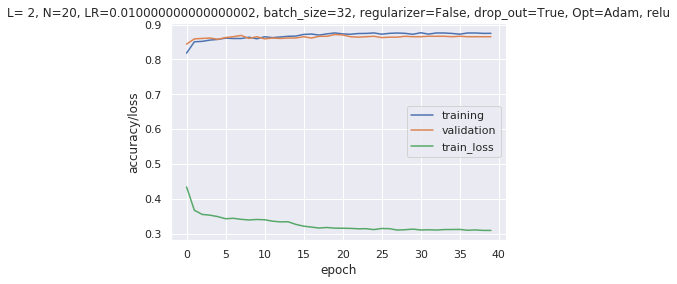

F1_Train = 0.6568658116984673, F1_Test = 0.6053639846743295,
Acc_Train = 0.862875, Acc_Test = 0.8455, Precision=0.6388140161725068, Recall =0.5752427184466019
[[1454  134]
 [ 175  237]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00025: early stopping
optimalTh= 0.37988913


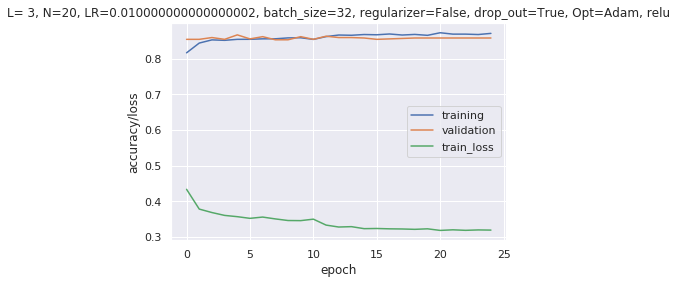

F1_Train = 0.6557484441532918, F1_Test = 0.598105548037889,
Acc_Train = 0.868625, Acc_Test = 0.8515, Precision=0.6758409785932722, Recall =0.5364077669902912
[[1482  106]
 [ 191  221]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00025: early stopping
optimalTh= 0.35444856


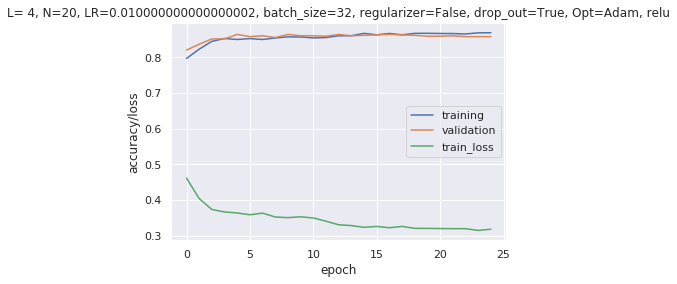

F1_Train = 0.6606914212548015, F1_Test = 0.6041666666666666,
Acc_Train = 0.8675, Acc_Test = 0.848, Precision=0.651685393258427, Recall =0.5631067961165048
[[1464  124]
 [ 180  232]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00042: early stopping
optimalTh= 0.27034068


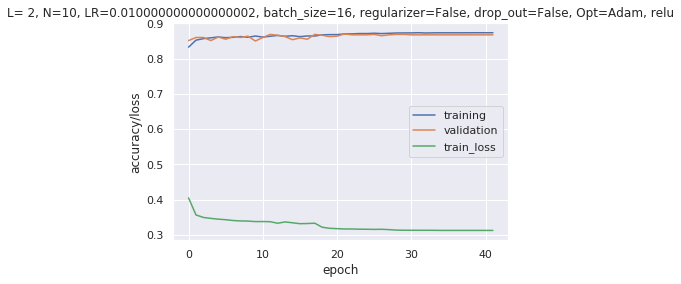

F1_Train = 0.6477337923121056, F1_Test = 0.5867287543655413,
Acc_Train = 0.8465, Acc_Test = 0.8225, Precision=0.5637583892617449, Recall =0.6116504854368932
[[1393  195]
 [ 160  252]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00025: early stopping
optimalTh= 0.3132469


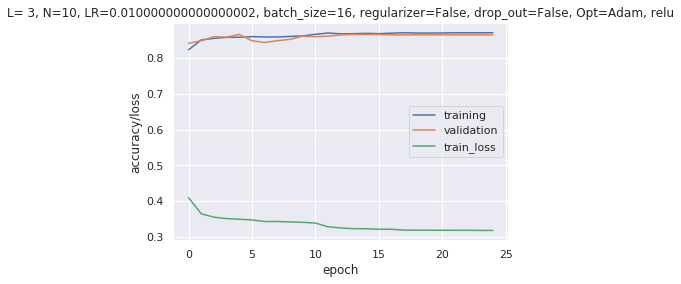

F1_Train = 0.6447494414299393, F1_Test = 0.5834394904458599,
Acc_Train = 0.860875, Acc_Test = 0.8365, Precision=0.613941018766756, Recall =0.5558252427184466
[[1444  144]
 [ 183  229]]




Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00030: early stopping
optimalTh= 0.33015808


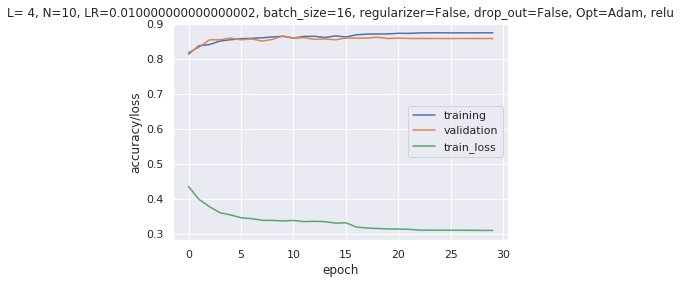

F1_Train = 0.6625039025913205, F1_Test = 0.5902061855670102,
Acc_Train = 0.864875, Acc_Test = 0.841, Precision=0.6291208791208791, Recall =0.5558252427184466
[[1453  135]
 [ 183  229]]




Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00024: early stopping
optimalTh= 0.32337508


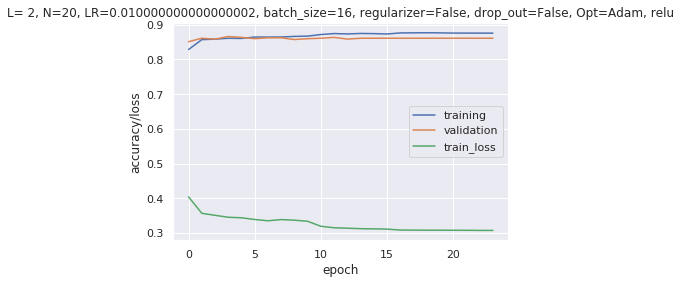

F1_Train = 0.6551398931153727, F1_Test = 0.5868725868725869,
Acc_Train = 0.862875, Acc_Test = 0.8395, Precision=0.6246575342465753, Recall =0.5533980582524272
[[1451  137]
 [ 184  228]]




Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00025: early stopping
optimalTh= 0.31582123


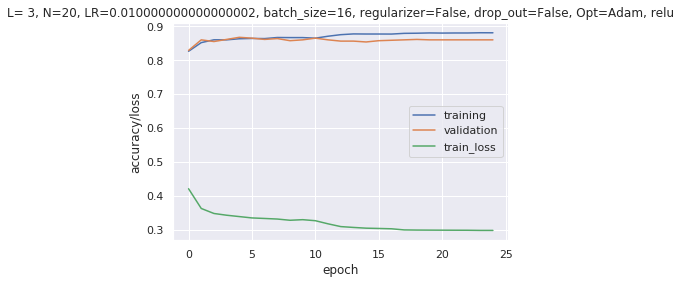

F1_Train = 0.6647673314339981, F1_Test = 0.6005154639175256,
Acc_Train = 0.867625, Acc_Test = 0.845, Precision=0.6401098901098901, Recall =0.5655339805825242
[[1457  131]
 [ 179  233]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00046: early stopping
optimalTh= 0.32919127


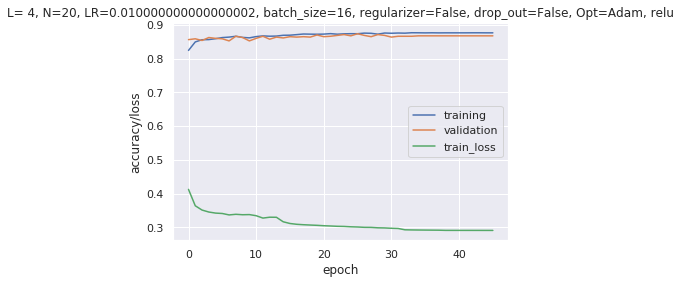

F1_Train = 0.6715514495062122, F1_Test = 0.5905006418485237,
Acc_Train = 0.871125, Acc_Test = 0.8405, Precision=0.6267029972752044, Recall =0.558252427184466
[[1451  137]
 [ 182  230]]




Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00044: early stopping
optimalTh= 0.3206455


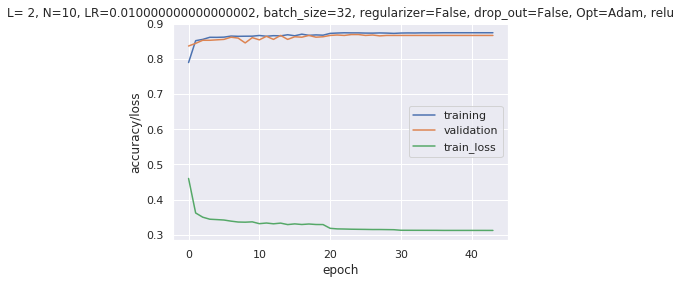

F1_Train = 0.6479672234478412, F1_Test = 0.5798212005108556,
Acc_Train = 0.860375, Acc_Test = 0.8355, Precision=0.6118598382749326, Recall =0.5509708737864077
[[1444  144]
 [ 185  227]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00028: early stopping
optimalTh= 0.34468842


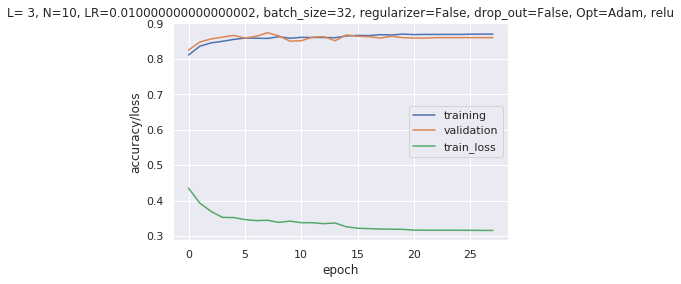

F1_Train = 0.6400765794511806, F1_Test = 0.5961290322580645,
Acc_Train = 0.859, Acc_Test = 0.8435, Precision=0.6363636363636364, Recall =0.5606796116504854
[[1456  132]
 [ 181  231]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00034: early stopping
optimalTh= 0.35349393


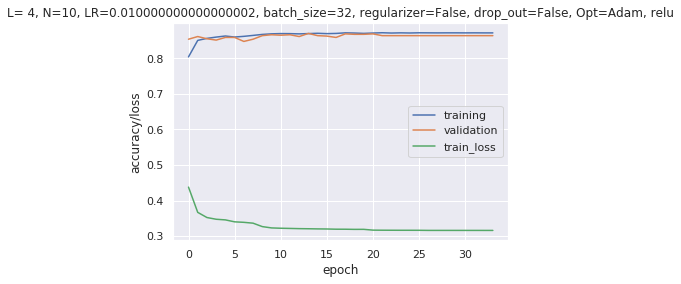

F1_Train = 0.642668428005284, F1_Test = 0.5850340136054423,
Acc_Train = 0.86475, Acc_Test = 0.8475, Precision=0.6656346749226006, Recall =0.5218446601941747
[[1480  108]
 [ 197  215]]




Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00029: early stopping
optimalTh= 0.33137017


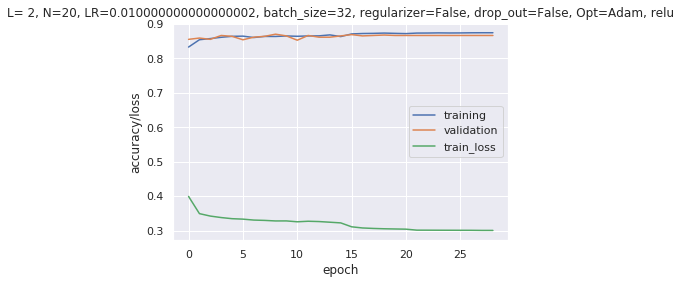

F1_Train = 0.6596664607782582, F1_Test = 0.5918367346938774,
Acc_Train = 0.86225, Acc_Test = 0.84, Precision=0.6236559139784946, Recall =0.5631067961165048
[[1448  140]
 [ 180  232]]




Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00028: early stopping
optimalTh= 0.29701495


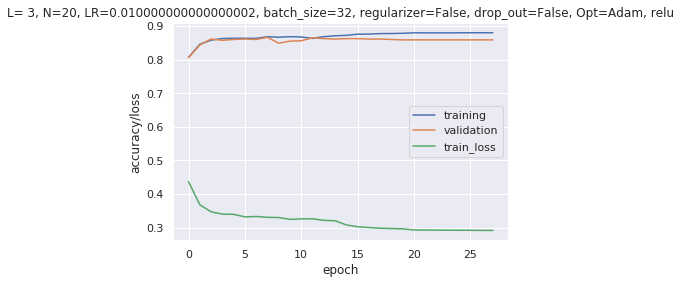

F1_Train = 0.6617298578199052, F1_Test = 0.6161251504211792,
Acc_Train = 0.85725, Acc_Test = 0.8405, Precision=0.6109785202863962, Recall =0.6213592233009708
[[1425  163]
 [ 156  256]]




Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00026: early stopping
optimalTh= 0.32108048


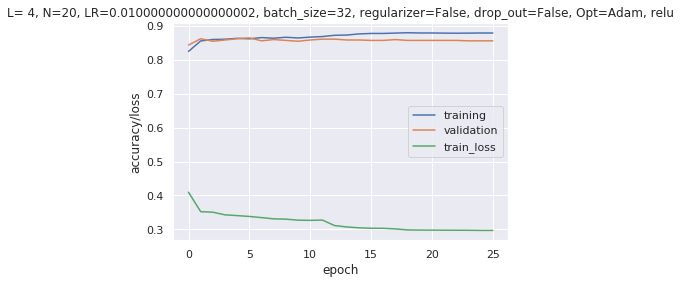

F1_Train = 0.6533078880407125, F1_Test = 0.612565445026178,
Acc_Train = 0.86375, Acc_Test = 0.852, Precision=0.6647727272727273, Recall =0.5679611650485437
[[1470  118]
 [ 178  234]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


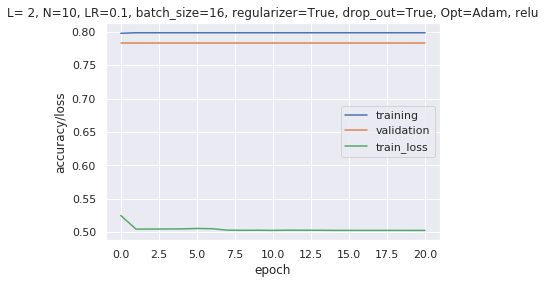

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


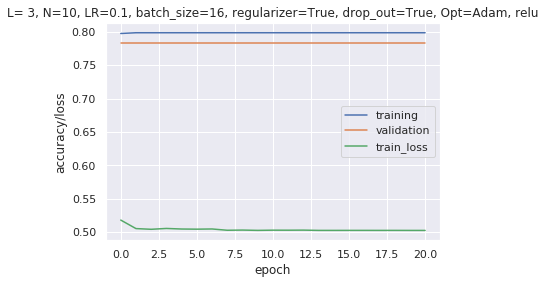

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


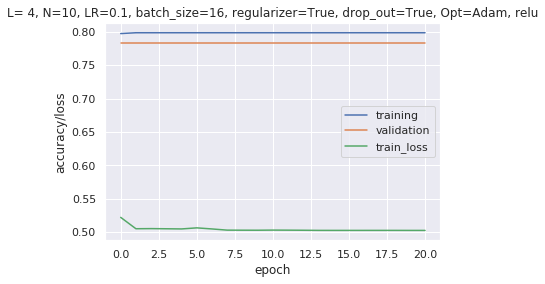

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


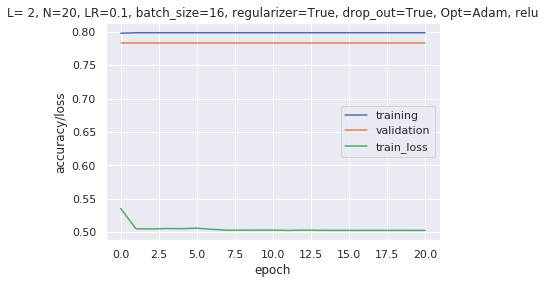

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


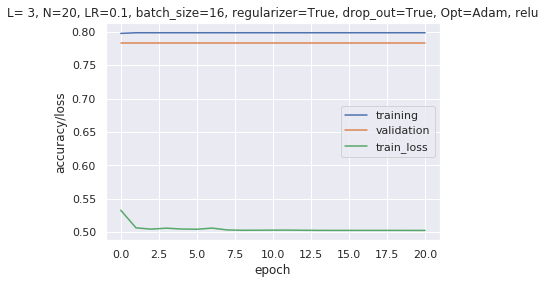

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


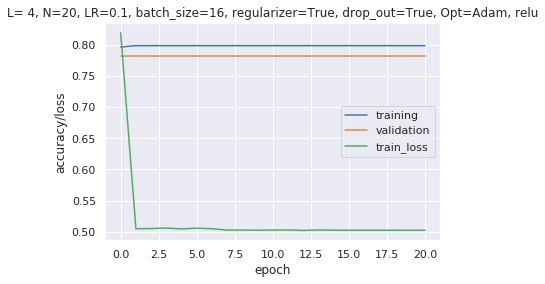

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0.24849412


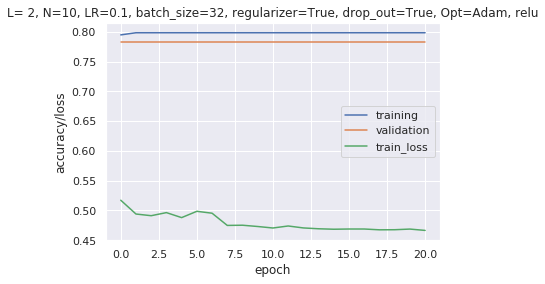

F1_Train = 0.5163833456516383, F1_Test = 0.5014520813165537,
Acc_Train = 0.754625, Acc_Test = 0.7425, Precision=0.4170692431561997, Recall =0.6286407766990292
[[1226  362]
 [ 153  259]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


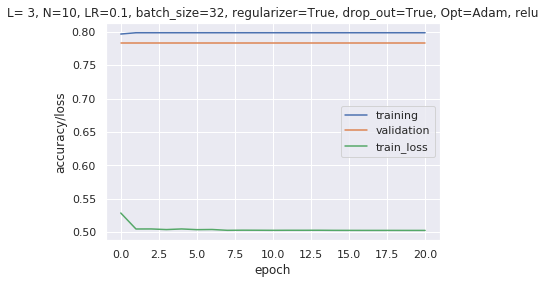

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


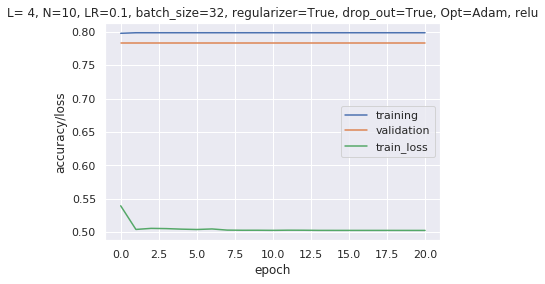

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00032: early stopping
optimalTh= 0.21024588


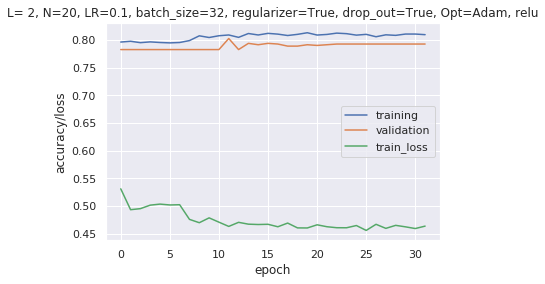

F1_Train = 0.5029527559055118, F1_Test = 0.4865403788634098,
Acc_Train = 0.7475, Acc_Test = 0.7425, Precision=0.4128595600676819, Recall =0.5922330097087378
[[1241  347]
 [ 168  244]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


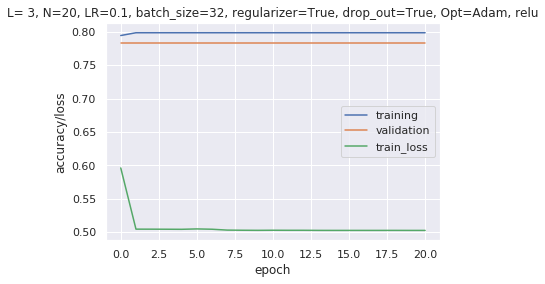

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


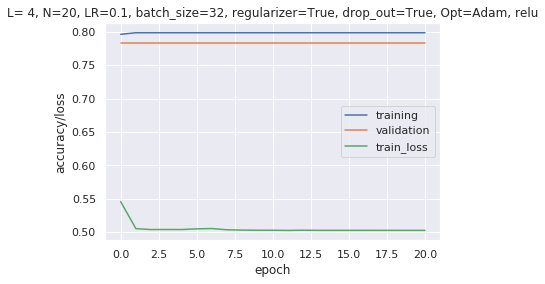

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00029: early stopping
optimalTh= 0.22481743


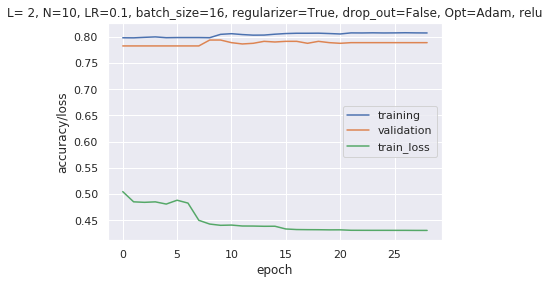

F1_Train = 0.5153719784088242, F1_Test = 0.499535747446611,
Acc_Train = 0.741875, Acc_Test = 0.7305, Precision=0.4045112781954887, Recall =0.6529126213592233
[[1192  396]
 [ 143  269]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


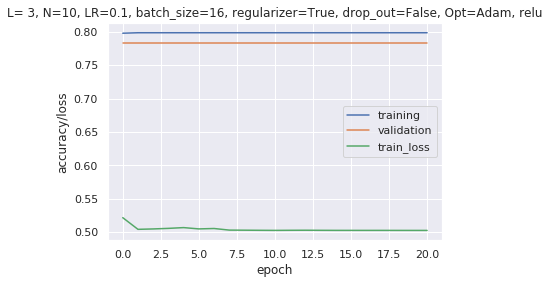

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


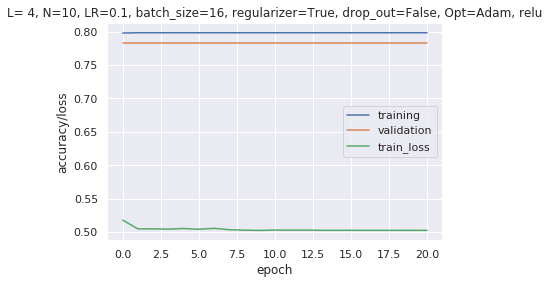

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00029: early stopping
optimalTh= 0.21078399


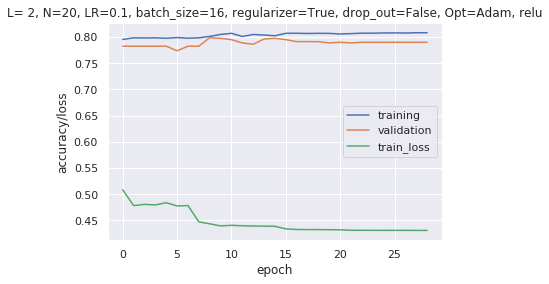

F1_Train = 0.5137861466039004, F1_Test = 0.4955277280858676,
Acc_Train = 0.728875, Acc_Test = 0.718, Precision=0.3923512747875354, Recall =0.6723300970873787
[[1159  429]
 [ 135  277]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


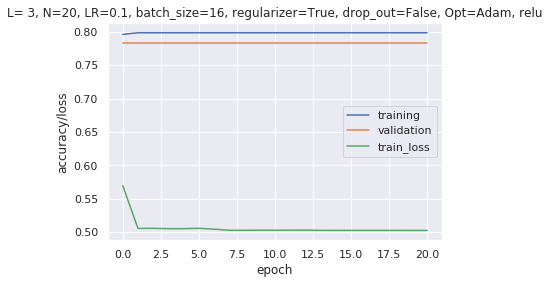

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


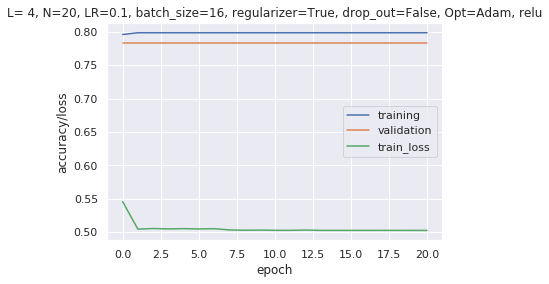

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 00040: early stopping
optimalTh= 0.21184397


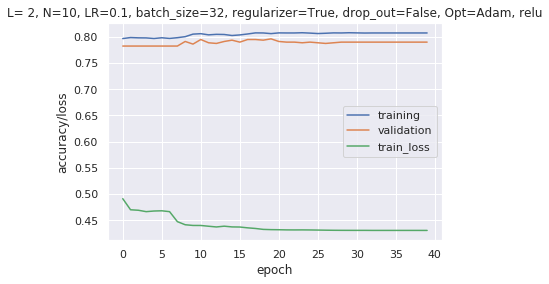

F1_Train = 0.5150697255960415, F1_Test = 0.4950672645739911,
Acc_Train = 0.7305, Acc_Test = 0.7185, Precision=0.39260312944523473, Recall =0.6699029126213593
[[1161  427]
 [ 136  276]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00034: early stopping
optimalTh= 0.21761706


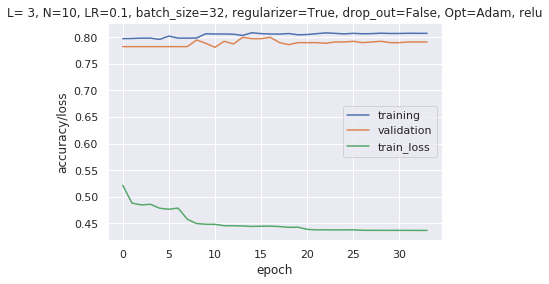

F1_Train = 0.512434405658225, F1_Test = 0.49362477231329693,
Acc_Train = 0.732875, Acc_Test = 0.722, Precision=0.39504373177842567, Recall =0.6577669902912622
[[1173  415]
 [ 141  271]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


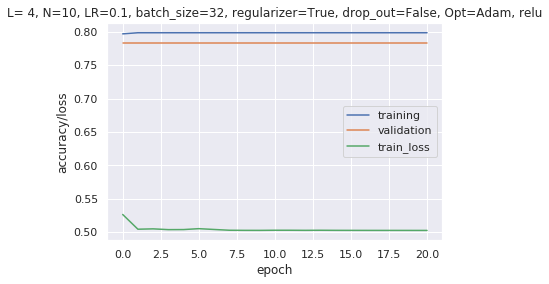

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00030: early stopping
optimalTh= 0.2146751


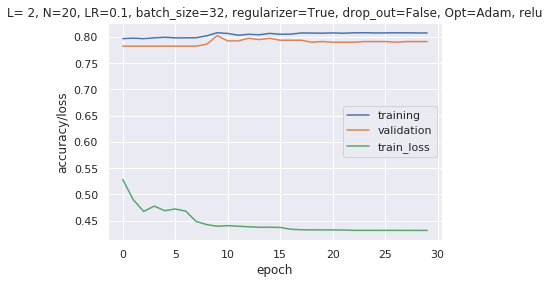

F1_Train = 0.5133908306854289, F1_Test = 0.4932249322493225,
Acc_Train = 0.732, Acc_Test = 0.7195, Precision=0.39280575539568346, Recall =0.662621359223301
[[1166  422]
 [ 139  273]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00033: early stopping
optimalTh= 0.21303341


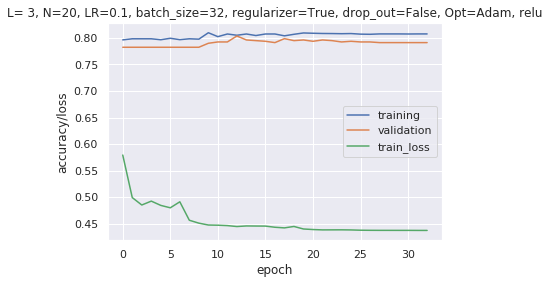

F1_Train = 0.5114382785956966, F1_Test = 0.49009009009009014,
Acc_Train = 0.730375, Acc_Test = 0.717, Precision=0.38968481375358166, Recall =0.6601941747572816
[[1162  426]
 [ 140  272]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


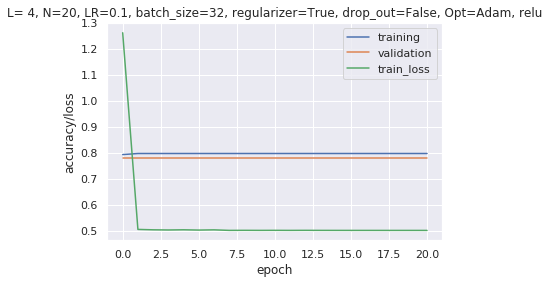

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


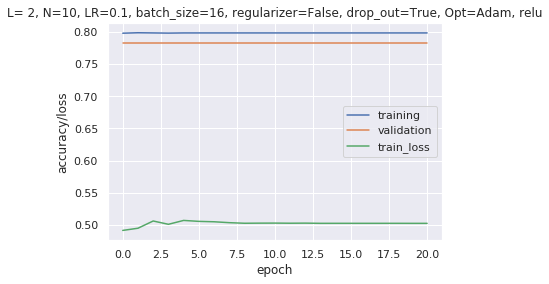

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0.19743845


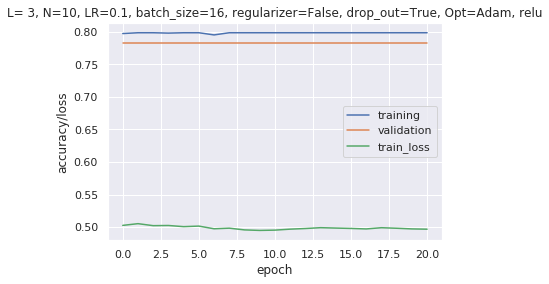

F1_Train = 0.15580597746202843, F1_Test = 0.1381957773512476,
Acc_Train = 0.784625, Acc_Test = 0.7755, Precision=0.3302752293577982, Recall =0.08737864077669903
[[1515   73]
 [ 376   36]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


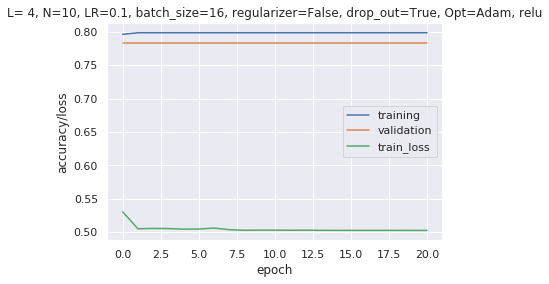

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


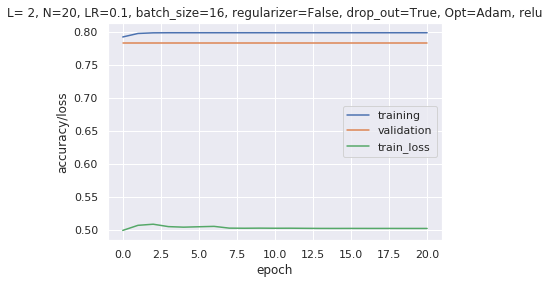

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0.2106528


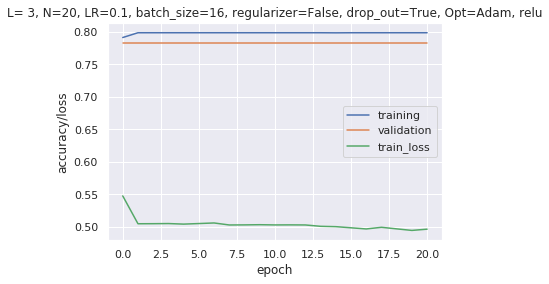

F1_Train = 0.3700284090909091, F1_Test = 0.376425855513308,
Acc_Train = 0.33475, Acc_Test = 0.344, Precision=0.23404255319148937, Recall =0.9611650485436893
[[ 292 1296]
 [  16  396]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


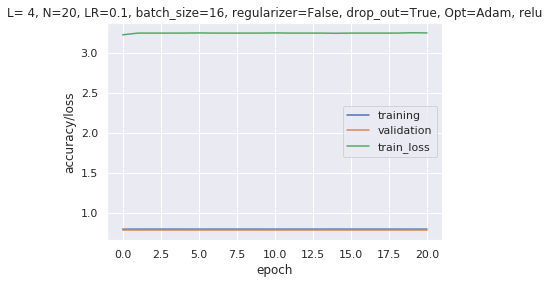

F1_Train = 0.0, F1_Test = 0.0,
Acc_Train = 0.796875, Acc_Test = 0.794, Precision=0.0, Recall =0.0
[[1588    0]
 [ 412    0]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0.36444134


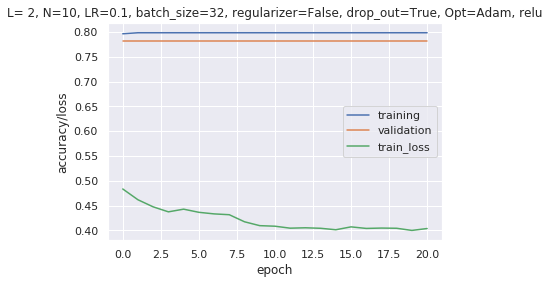

F1_Train = 0.6241528034504006, F1_Test = 0.5849999999999999,
Acc_Train = 0.8475, Acc_Test = 0.834, Precision=0.6030927835051546, Recall =0.5679611650485437
[[1434  154]
 [ 178  234]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


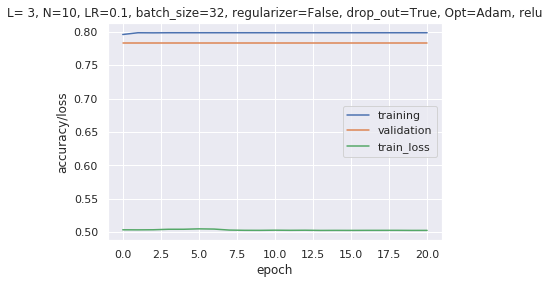

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


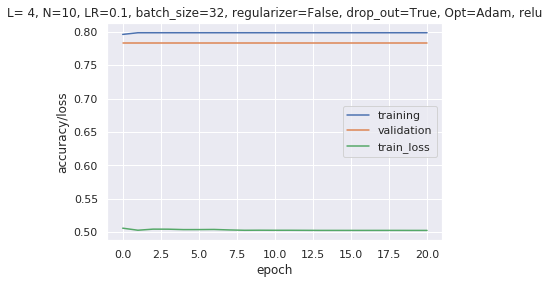

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00023: early stopping
optimalTh= 0.083645344


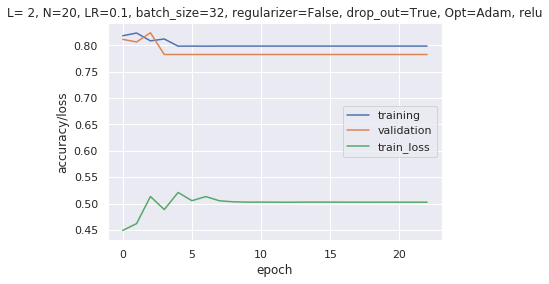

F1_Train = 0.3376974231088944, F1_Test = 0.3416252072968491,
Acc_Train = 0.20325, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


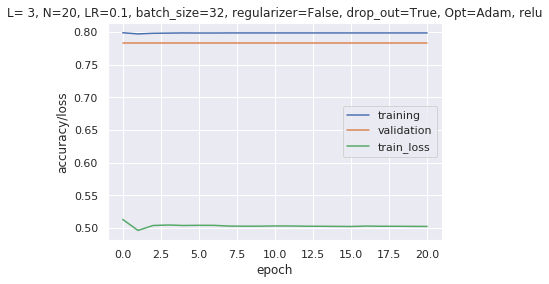

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


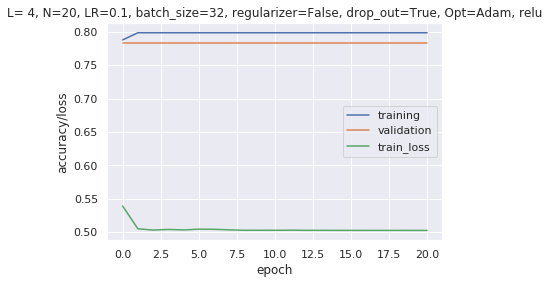

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 00061: early stopping
optimalTh= 0.3396616


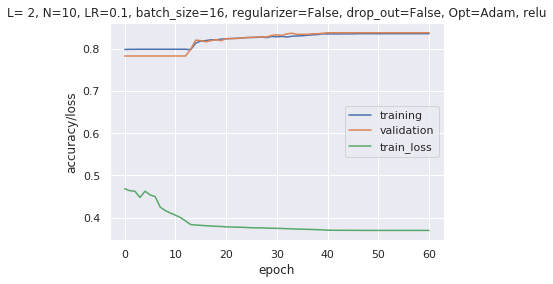

F1_Train = 0.593625498007968, F1_Test = 0.5648148148148148,
Acc_Train = 0.8215, Acc_Test = 0.812, Precision=0.5398230088495575, Recall =0.5922330097087378
[[1380  208]
 [ 168  244]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


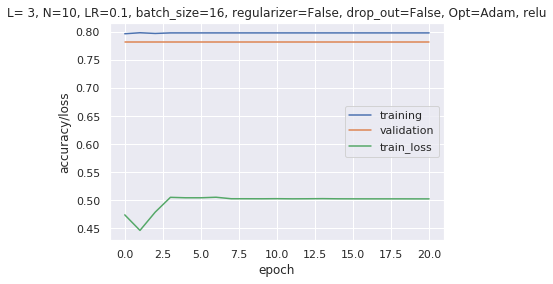

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


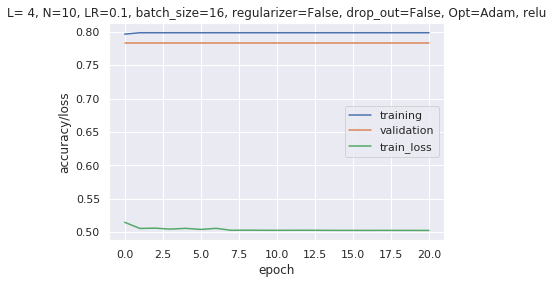

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00022: early stopping
optimalTh= 0


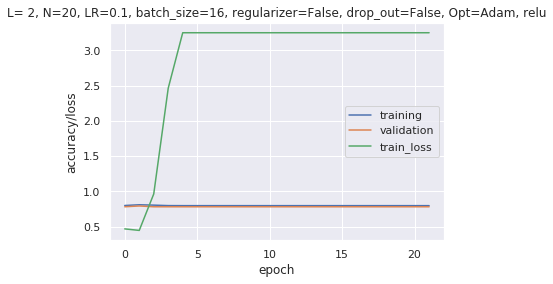

F1_Train = 0.0, F1_Test = 0.0,
Acc_Train = 0.796875, Acc_Test = 0.794, Precision=0.0, Recall =0.0
[[1588    0]
 [ 412    0]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


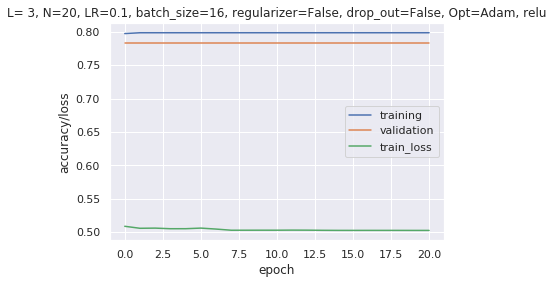

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


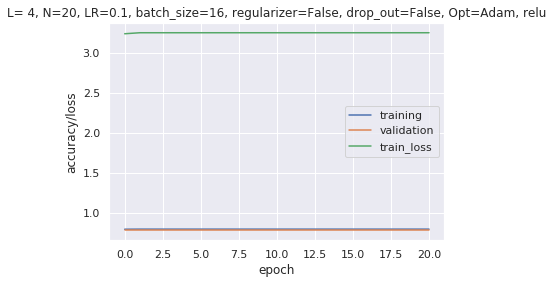

F1_Train = 0.0, F1_Test = 0.0,
Acc_Train = 0.796875, Acc_Test = 0.794, Precision=0.0, Recall =0.0
[[1588    0]
 [ 412    0]]




Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00032: early stopping
optimalTh= 0.32513273


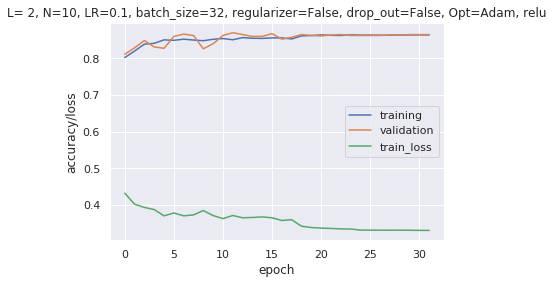

F1_Train = 0.6355721393034827, F1_Test = 0.5982028241335045,
Acc_Train = 0.8535, Acc_Test = 0.8435, Precision=0.6348773841961853, Recall =0.5655339805825242
[[1454  134]
 [ 179  233]]




Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00022: early stopping
optimalTh= 0.5384274


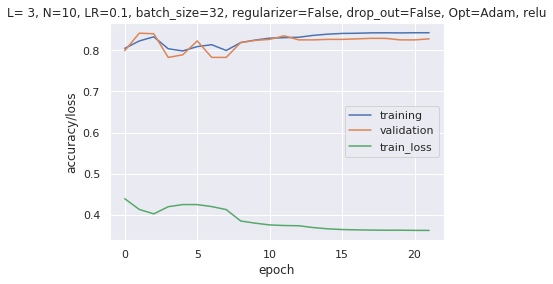

F1_Train = 0.6034912718204489, F1_Test = 0.5616264294790343,
Acc_Train = 0.841, Acc_Test = 0.8275, Precision=0.5893333333333334, Recall =0.5364077669902912
[[1434  154]
 [ 191  221]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


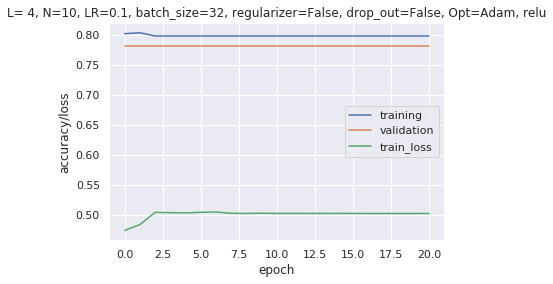

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00041: early stopping
optimalTh= 0.29714066


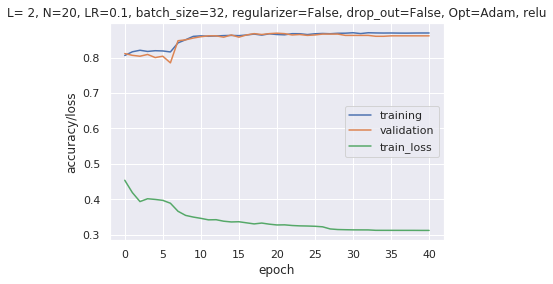

F1_Train = 0.6565064478311841, F1_Test = 0.6097271648873073,
Acc_Train = 0.8535, Acc_Test = 0.8355, Precision=0.5962877030162413, Recall =0.6237864077669902
[[1414  174]
 [ 155  257]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0.24385363


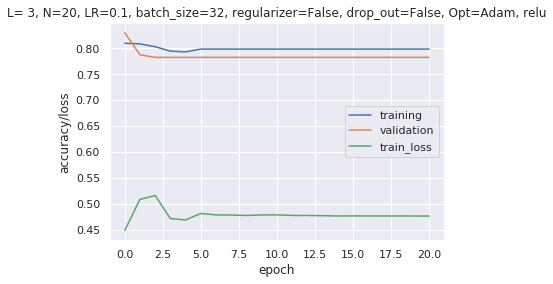

F1_Train = 0.4224461568859909, F1_Test = 0.43690851735015773,
Acc_Train = 0.634625, Acc_Test = 0.643, Precision=0.3235981308411215, Recall =0.6723300970873787
[[1009  579]
 [ 135  277]]




Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 00021: early stopping
optimalTh= 0


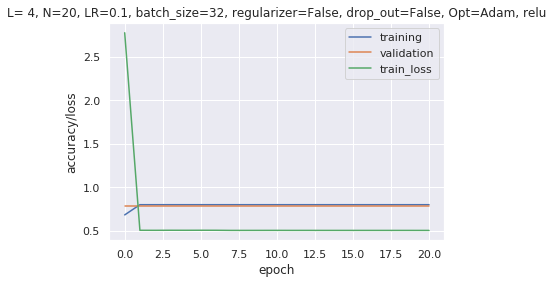

F1_Train = 0.33766233766233766, F1_Test = 0.3416252072968491,
Acc_Train = 0.203125, Acc_Test = 0.206, Precision=0.206, Recall =1.0
[[   0 1588]
 [   0  412]]





In [57]:
models = []
EPOCHS = 700
for r in [-3, -2, -1, 0]:
    lr = 0.1 * (10**r)
    for reg in [True, False]:
            for drop in [True, False]:
                for b_size in [16, 32]:
                    for nodes in [10, 20]:
                        for layers in range(2, 5):
                            optimizer = Adam(lr=lr)
                            model = create_dense([nodes] * layers, opt=optimizer, regularize=reg,  dropout=drop )
                            desc = f'L= {layers}, N={nodes}, LR={lr}, batch_size={b_size}, regularizer={reg}, drop_out={drop}, Opt=Adam, relu'
                            res = evaluate(model, batch_size=b_size, epochs=EPOCHS, desc=desc)
                            results.loc[len(results)] = [desc] + res
                            models.append(model)

In [58]:
results.style.apply(highlight_max, axis=0)

In [59]:

results['F1_TEST'] = results['F1_TEST'].astype('float')
results['Optimal_Threshold'] = results['Optimal_Threshold'].astype('float')

# Let's select the model with best F1 TEST Score
final_model_id = results['F1_TEST'].idxmax()
print(final_model_id)
final_model = models[final_model_id]
optimalTh = results.loc[final_model_id]['Optimal_Threshold']
print(optimalTh)

y_pred = final_model.predict(x_train, batch_size=b_size)
y_pred = np.where(y_pred > optimalTh, 1, 0)

print(classification_report(y_train, y_pred))


87
0.2892876863479614
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      6375
           1       0.61      0.68      0.64      1625

    accuracy                           0.85      8000
   macro avg       0.76      0.79      0.77      8000
weighted avg       0.85      0.85      0.85      8000



In [0]:
from google.colab import files

results.to_csv('final_results.csv')

files.download('final_results.csv')

